#### Author: Michael Creegan

Assignment:
* Use the publicly available IMDB Datasets located on https://www.imdb.com/interfaces/ to build a model that predicts a movie’s average rating. 
* Do not pull in any outside information (only these files)

This notebook is formated into 5 sections:
* 1. Exploratory data analysis
* 2. Feature creation
* 3. Data Cleaning
* 4. Modeling
* 5. Conclusion 

# Part 1: Exploratory data analysis
* We will explore the 6 files in https://www.imdb.com/interfaces/ to create a the underlying data we can use to predict movie ratings

### 1.1 Import Libraries

In [1]:
import os
import fnmatch
import glob
import numpy as np
import pandas as pd
import requests
import re
import traceback
import unicodedata
import matplotlib.pyplot as plt
import pycountry
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from category_encoders.one_hot import OneHotEncoder
from sklearn.feature_selection import RFE

#### 1.2 Load IMDB files

In [2]:
# get all gz files 
path = '/home/creeg/projects/audible/imdb_data'
imdb_files = glob.glob(os.path.join(path, "*.gz"))

In [3]:
for i in range(len(imdb_files)):
    print(imdb_files[i])

/home/creeg/projects/audible/imdb_data/name.basics.tsv.gz
/home/creeg/projects/audible/imdb_data/title.basics.tsv.gz
/home/creeg/projects/audible/imdb_data/title.principals.tsv.gz
/home/creeg/projects/audible/imdb_data/title.akas.tsv.gz
/home/creeg/projects/audible/imdb_data/title.ratings.tsv.gz
/home/creeg/projects/audible/imdb_data/title.crew.tsv.gz


### 1.3 Load ratings / y variable

In [4]:
ratings = pd.read_csv('/home/creeg/projects/audible/imdb_data/title.ratings.tsv.gz'
                           , sep='\t'
                           , low_memory=False
                           , na_values = ["\\N","nan"])

In [5]:
# checking if any titles have null values for the y variable

ratings.isna().sum()

tconst           0
averageRating    0
numVotes         0
dtype: int64

### 1.4 Load Movie Titles
* this data contains descriptive features about imdb titles including type(movie, tv series, etc..), adult film, start year, runtime, and genre

In [6]:
title_basics = pd.read_csv('/home/creeg/projects/audible/imdb_data/title.basics.tsv.gz'
                           , sep='\t'
                           , low_memory=False
                           , na_values = ["\\N","nan"])

In [7]:
# checking for null values

title_basics.isna().sum()

tconst                  0
titleType               0
primaryTitle           11
originalTitle          11
isAdult                 1
startYear         1210171
endYear           9029621
runtimeMinutes    6669097
genres             415378
dtype: int64

In [8]:
# looking for unique title types

title_basics['titleType'].unique()

array(['short', 'movie', 'tvEpisode', 'tvSeries', 'tvShort', 'tvMovie',
       'tvMiniSeries', 'tvSpecial', 'video', 'videoGame', 'tvPilot'],
      dtype=object)

In [9]:
# filtering data to only include movie titles

title_basics = title_basics[title_basics['titleType'] == 'movie']

In [10]:
# Looking to see if there are differences between original title and primary title. 
# I see films in foreign languages differ

title_basics.loc[~(title_basics['primaryTitle'] == title_basics['originalTitle'])].head()

tconst titleType               primaryTitle         originalTitle  \
587   tt0000591     movie           The Prodigal Son     L'enfant prodigue   
625   tt0000630     movie                     Hamlet                Amleto   
876   tt0000886     movie  Hamlet, Prince of Denmark                Hamlet   
1110  tt0001122     movie                The Red Inn       L'auberge rouge   
1163  tt0001175     movie                    Camille  La dame aux camélias   

      isAdult  startYear  endYear runtimeMinutes         genres  
587       0.0     1907.0      NaN             90          Drama  
625       0.0     1908.0      NaN            NaN          Drama  
876       0.0     1910.0      NaN            NaN          Drama  
1110      0.0     1910.0      NaN            NaN            NaN  
1163      0.0     1912.0      NaN            NaN  Drama,Romance

In [11]:
# removing films end year column since this is not applicable to movies 

title_basics.drop('endYear', axis=1, inplace=True)

In [12]:
# cast startYear as an integer

title_basics['startYear'] = title_basics['startYear'].astype('Int64')

In [13]:
# display range of films

f"min year is: {title_basics.startYear.min()}, max year is: {title_basics.startYear.max()}"

'min year is: 1894, max year is: 2029'

In [14]:
# looking at what data has start year greater than today

title_basics[title_basics['startYear'] > 2022].head()

tconst titleType             primaryTitle            originalTitle  \
158735  tt0164115     movie                Nine Ball                Nine Ball   
173208  tt0179538     movie                     Wilt                     Wilt   
409955  tt0427340     movie  Masters of the Universe  Masters of the Universe   
421864  tt0439572     movie                The Flash                The Flash   
736439  tt0760323     movie               Slow Moses               Slow Moses   

        isAdult  startYear runtimeMinutes                    genres  
158735      0.0       2023            NaN                       NaN  
173208      0.0       2024            NaN                     Drama  
409955      0.0       2024            NaN    Action,Adventure,Drama  
421864      0.0       2023            NaN  Action,Adventure,Fantasy  
736439      0.0       2023             93                     Drama

In [15]:
# cast is adult as integer 

title_basics['isAdult'] = title_basics['isAdult'].astype('int64')

### 1.5 Merge titles and ratings

In [16]:
basic_ratings = pd.merge(title_basics, ratings, how='left', on = 'tconst')

In [17]:
# sanity check post merge

len(title_basics), len(basic_ratings)

(617537, 617537)

In [18]:
# checking for films that do not have a y variable

basic_ratings['averageRating'].isna().sum()

336920

In [19]:
# dropping nulls

basic_ratings = basic_ratings.dropna(subset=['averageRating'])

### 1.6 Explore release year, runtime, and rating

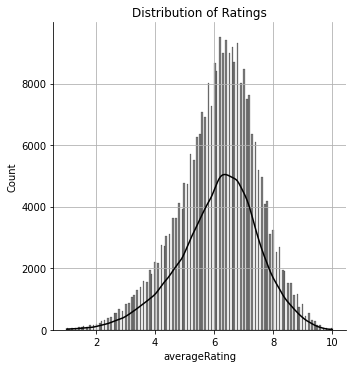

In [20]:
# we can see the majority of ratings are concentrated between ~6-8

sns.displot(x=basic_ratings['averageRating'], color = 'black',kde=True,height=5)
plt.title('Distribution of Ratings')
plt.grid()

In [21]:
# checking for start year null values
# removing the null values from the data

basic_ratings = basic_ratings[basic_ratings['startYear'] != '<NA>']

In [22]:
basic_ratings[basic_ratings['startYear'].isnull()].sum().sum()

0.0

In [23]:
len(basic_ratings[basic_ratings['runtimeMinutes'].isna()])

28023

In [24]:
# filtering out films where runtime is null

basic_ratings = basic_ratings[basic_ratings['runtimeMinutes'].notna()]

In [25]:
len(basic_ratings[basic_ratings['runtimeMinutes'].isna()])

0

### 1.7 Load title and crew data
* this data contains the director and writer information for the titles in imdb

In [26]:
# load identifiers

name_ids = pd.read_csv('/home/creeg/projects/audible/imdb_data/title.crew.tsv.gz'
                           , sep='\t'
                           , low_memory=False
                           , na_values = ["\\N","nan"])

In [27]:
# load human readable names

names_dir = pd.read_csv('/home/creeg/projects/audible/imdb_data/name.basics.tsv.gz'
                           , sep='\t'
                           , low_memory=False
                           , na_values = ["\\N","nan"])

In [28]:
# merge the id data into existing data on movie id

basic_ratings_dir = pd.merge(basic_ratings,name_ids, on="tconst",how="left")
basic_ratings_dir.head(10)

tconst titleType                    primaryTitle  \
0  tt0000009     movie                      Miss Jerry   
1  tt0000502     movie                        Bohemios   
2  tt0000574     movie     The Story of the Kelly Gang   
3  tt0000591     movie                The Prodigal Son   
4  tt0000679     movie  The Fairylogue and Radio-Plays   
5  tt0001184     movie         Don Juan de Serrallonga   
6  tt0001285     movie               The Life of Moses   
7  tt0001498     movie         The Battle of Trafalgar   
8  tt0001592     movie            In the Prime of Life   
9  tt0001630     movie                Der fremde Vogel   

                    originalTitle  isAdult  startYear runtimeMinutes  \
0                      Miss Jerry        0       1894             45   
1                        Bohemios        0       1905            100   
2     The Story of the Kelly Gang        0       1906             70   
3               L'enfant prodigue        0       1907             90   
4  The Fairylogue and Radio-Plays        0       1908            120   
5         Don Juan de Serrallonga        0       1910             58   
6               The Life of Moses        0       1909             50   
7         The Battle of Trafalgar        0       1911             51   
8                   Ekspeditricen        0       1911             52   
9                Der fremde Vogel        0       1911             45   

                       genres  averageRating  numVotes            directors  \
0                     Romance            5.3     198.0            nm0085156   
1                         NaN            4.5      14.0            nm0063413   
2  Action,Adventure,Biography            6.0     778.0            nm0846879   
3                       Drama            4.7      19.0            nm0141150   
4           Adventure,Fantasy            5.3      66.0  nm0877783,nm0091767   
5             Adventure,Drama            3.9      20.0  nm0063413,nm0550220   
6      Biography,Drama,Family            5.6      58.0            nm0085865   
7                         War            7.7      12.0            nm0205986   
8                       Drama            5.5      15.0            nm0088881   
9                         NaN            6.2      29.0            nm0300487   

                         writers  
0                      nm0085156  
1  nm0063413,nm0657268,nm0675388  
2                      nm0846879  
3                      nm0141150  
4            nm0000875,nm0877783  
5                      nm0049370  
6            nm0676645,nm0836316  
7                            NaN  
8                      nm0491503  
9                      nm0300487

In [29]:
# sanity check

len(basic_ratings_dir), len(basic_ratings)

(252552, 252552)

### 1.8 Explore directors and writers

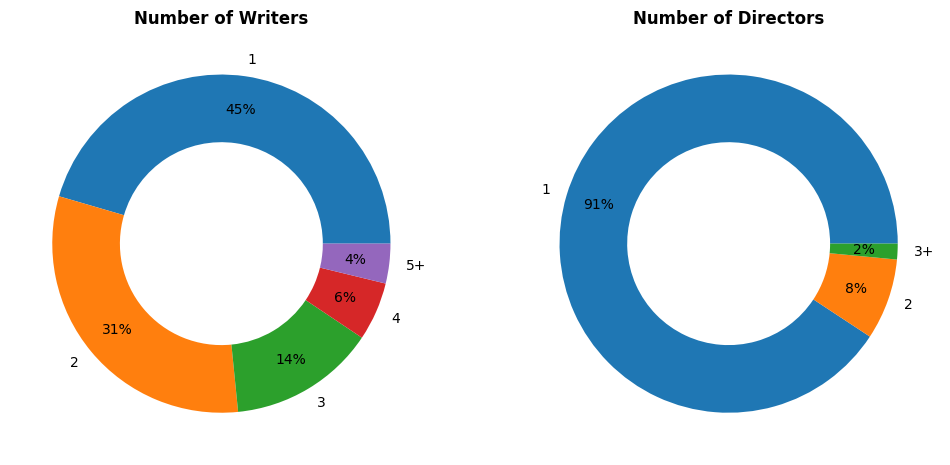

In [30]:
# shows that it is more common to have multiple writers than directors

writer_counts = basic_ratings_dir.writers.dropna().apply(lambda x: len(x.split(",")))
writer_counts[writer_counts>4] = "5+"

director_counts = basic_ratings_dir.directors.dropna().apply(lambda x: len(x.split(",")))
director_counts[director_counts>2] = "3+"

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

writer_counts.value_counts().plot.pie(autopct="%.0f%%"
                                      ,pctdistance=0.8
                                      ,wedgeprops=dict(width=0.4))

plt.title("Number of Writers",fontweight="bold")
plt.ylabel(None)
plt.subplot(1,2,2)

director_counts.value_counts().plot.pie(autopct="%.0f%%"
                                        ,pctdistance=0.8
                                        ,wedgeprops=dict(width=0.4))

plt.title("Number of Directors",fontweight="bold")
plt.ylabel(None)
plt.show()

In [31]:
# top films with multiple writers

writer_counts = basic_ratings_dir.writers.dropna().apply(lambda x: len(x.split(",")))
temp = basic_ratings_dir[["startYear","primaryTitle","writers"]].loc[writer_counts.nlargest(5).index]
temp["Writer Count"] = writer_counts.nlargest(5)
temp

startYear                                      primaryTitle  \
156601       2021  A Fandemic: 50 Fans Celebrate 50 Years of Cinema   
176028       2022                                        The Impact   
186508       2014                                         50 Kisses   
229210       2016                                    Spain in a Day   
210055       2016                                    World of Death   

                                                  writers  Writer Count  
156601  nm0026153,nm0064181,nm0115310,nm0158006,nm0158...            71  
176028  nm13554276,nm13554262,nm13554263,nm13554290,nm...            69  
186508  nm4270156,nm4380489,nm5443971,nm5443955,nm2478...            52  
229210  nm13077330,nm13077328,nm13428397,nm13077327,nm...            52  
210055  nm6031788,nm3421748,nm3792014,nm4900080,nm1562...            48

In [32]:
# top films with multiple directors

director_counts = basic_ratings_dir.directors.dropna().apply(lambda x: len(x.split(",")))
temp = basic_ratings_dir[["startYear","primaryTitle","directors"]].loc[director_counts.nlargest(5).index]
temp["Director Count"] = director_counts.nlargest(5)
del basic_ratings
temp

startYear                                       primaryTitle  \
210055       2016                                     World of Death   
198463       2013                         Venice 70: Future Reloaded   
186066       2011  Milano 55,1. Cronaca di una settimana di passioni   
218427       2017                                  60 Seconds to Die   
204343       2014                                 Our RoboCop Remake   

                                                directors  Director Count  
210055  nm6775503,nm4718923,nm1121352,nm4673342,nm3877...              84  
198463  nm3121098,nm0415245,nm0225010,nm0107788,nm1503...              74  
186066  nm5143445,nm5159009,nm1050361,nm2375499,nm2455...              63  
218427  nm0019144,nm3859710,nm2597539,nm7684836,nm1346...              62  
204343  nm2682257,nm3364004,nm1543633,nm0564530,nm1263...              59

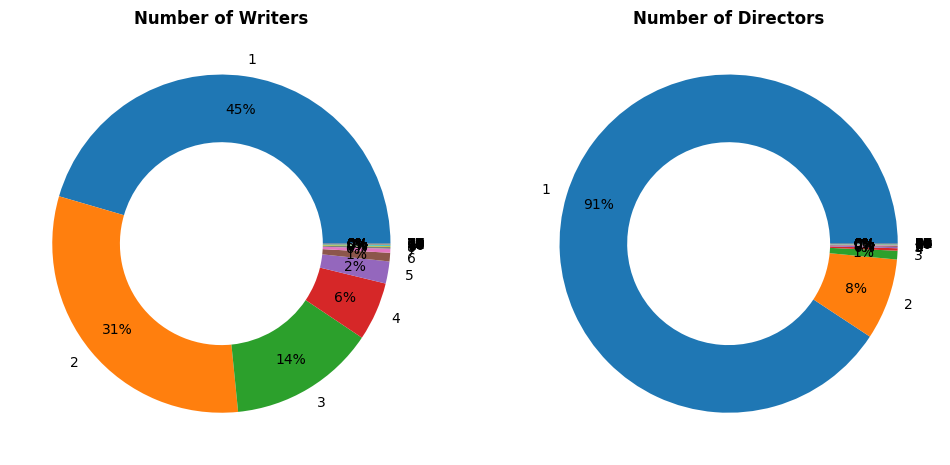

In [33]:
# visualizing number of writers compared to number of directors.
# 9 out of every 10 films only has one directors compared to roughly half of films having only 1 writer

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
writer_counts.value_counts().plot.pie(autopct="%.0f%%",pctdistance=0.8,
                                     wedgeprops=dict(width=0.4))
plt.title("Number of Writers",fontweight="bold")
plt.ylabel(None)
plt.subplot(1,2,2)
director_counts.value_counts().plot.pie(autopct="%.0f%%",pctdistance=0.8,
                                     wedgeprops=dict(width=0.4))
plt.title("Number of Directors",fontweight="bold")
plt.ylabel(None)
plt.show()

In [34]:
# getting director ids and names per movie 

director_temp = name_ids.drop("writers",axis=1)
director_temp.columns = ["tconst","nconst"]
director_temp.nconst = director_temp.nconst.dropna().apply(lambda x: x.split(",")[0])
directors = pd.merge(pd.merge(pd.merge(name_ids,ratings
                                       ,on="tconst")
                                        ,director_temp,on="tconst")
                                        ,names_dir[["nconst","primaryName"]],on="nconst")
del director_temp
directors.head()

tconst            directors writers  averageRating  numVotes     nconst  \
0  tt0000001            nm0005690     NaN            5.7      1902  nm0005690   
1  tt0000005            nm0005690     NaN            6.2      2517  nm0005690   
2  tt0000006            nm0005690     NaN            5.2       172  nm0005690   
3  tt0000007  nm0005690,nm0374658     NaN            5.4       784  nm0005690   
4  tt0000008            nm0005690     NaN            5.4      2042  nm0005690   

            primaryName  
0  William K.L. Dickson  
1  William K.L. Dickson  
2  William K.L. Dickson  
3  William K.L. Dickson  
4  William K.L. Dickson

In [35]:
directors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058383 entries, 0 to 1058382
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1058383 non-null  object 
 1   directors      1058383 non-null  object 
 2   writers        908747 non-null   object 
 3   averageRating  1058383 non-null  float64
 4   numVotes       1058383 non-null  int64  
 5   nconst         1058383 non-null  object 
 6   primaryName    1058383 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 64.6+ MB


In [36]:
# lists the top 10 directors, ordered by their median film ratings. 
# Include median vote counts per film, as well as the director’s film counts,Chris Nolan is the top director

director_success = directors[directors.numVotes>25000].groupby("primaryName").\
agg({"averageRating":[np.median],"numVotes":[np.median],"nconst":[np.size]}).\
sort_values(("averageRating","median"),ascending=False)
director_success[(director_success[("numVotes","median")]>100000)&(director_success[("nconst","size")]>3)].\
sort_values(("averageRating","median"),ascending=False).head(10)

averageRating   numVotes nconst
                         median     median   size
primaryName                                      
Christopher Nolan          8.40  1307903.0     11
Charles Chaplin            8.35   154267.5      6
Stanley Kubrick            8.30   340033.0     10
Sergio Leone               8.25   289891.0      6
Miguel Sapochnik           8.20   126034.5      8
Andrew Stanton             8.20  1028057.0      5
Quentin Tarantino          8.10   872594.0     10
David Lean                 8.10   147668.5      4
Frank Capra                8.10   103235.0      5
William Wyler              8.05   100893.0      4

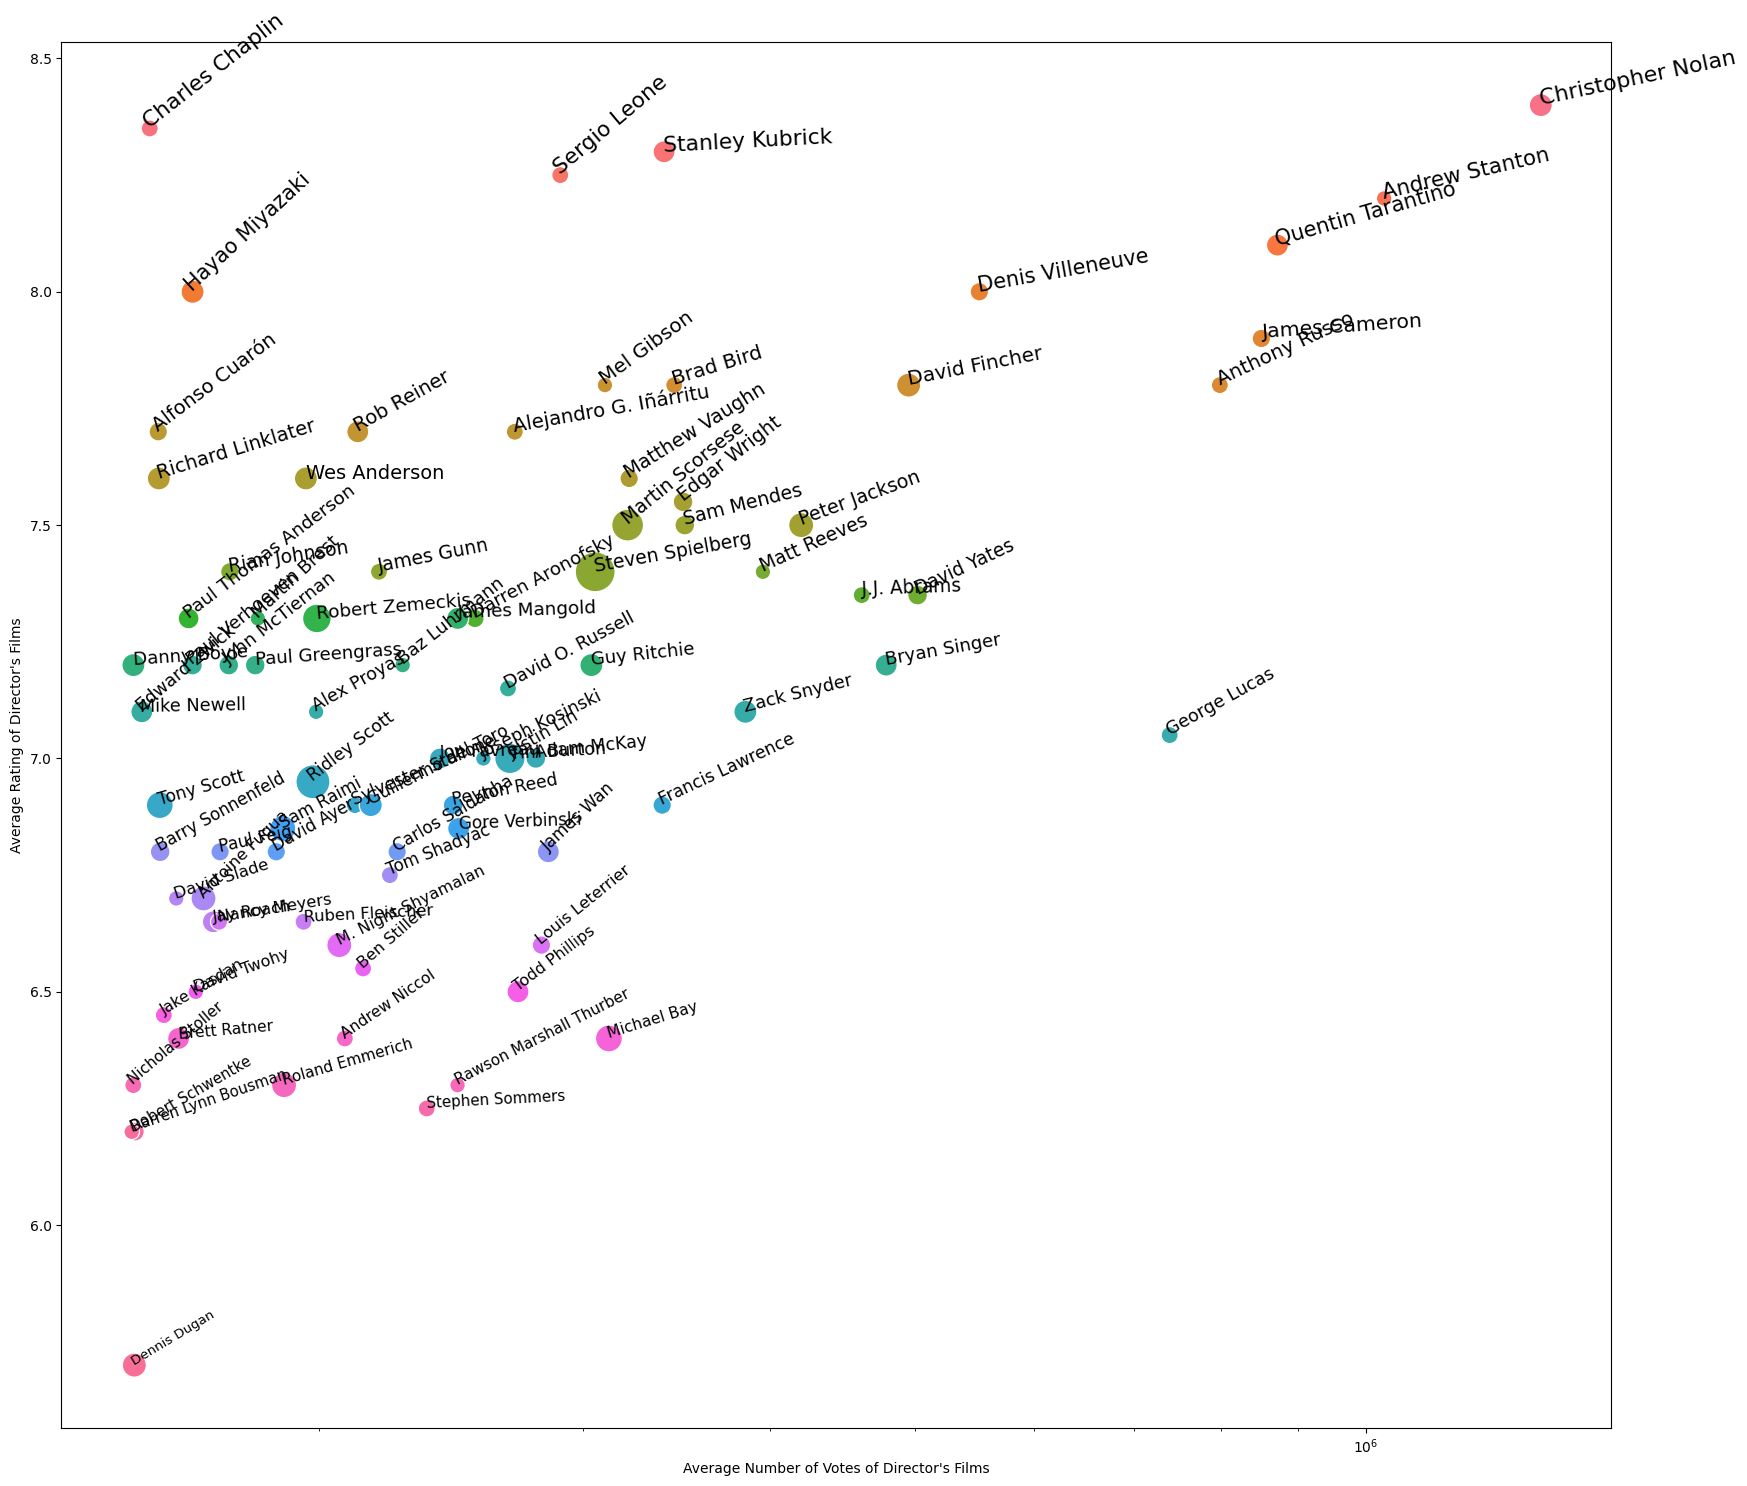

In [37]:
# visualize "success" for directors. directors higher on y scale have higher average ratings, directors on right hand have more popular films
# Chris Nolan has films that are both popular and have high prestiege among directors. Lets call this "quality". Charles Chaplin has quality but are not popular.

directors_successful = director_success[(director_success[("numVotes","median")]>150000)&\
                (director_success[("nconst","size")]>4)].sort_values(("averageRating","median"),ascending=False)


plt.figure(figsize=(20,18))
sns.scatterplot(y=directors_successful[("averageRating","median")]
                , x=directors_successful[("numVotes","median")]
                , s=directors_successful[("nconst")]*25,hue=directors_successful.index, legend=False,
               )
plt.xlabel("Average Number of Votes of Director's Films")
plt.ylabel("Average Rating of Director's Films")


# convert xaxis to log scale for better visualization & transpose
plt.gca().set_xscale("log")
for names in directors_successful.T:
    plt.text(directors_successful.T[names][("numVotes","median")],
            directors_successful.T[names][("averageRating","median")],
             names,rotation=np.random.randint(0,45), rotation_mode="anchor",
             fontsize=directors_successful.T[names][("averageRating","median")]**1.3)

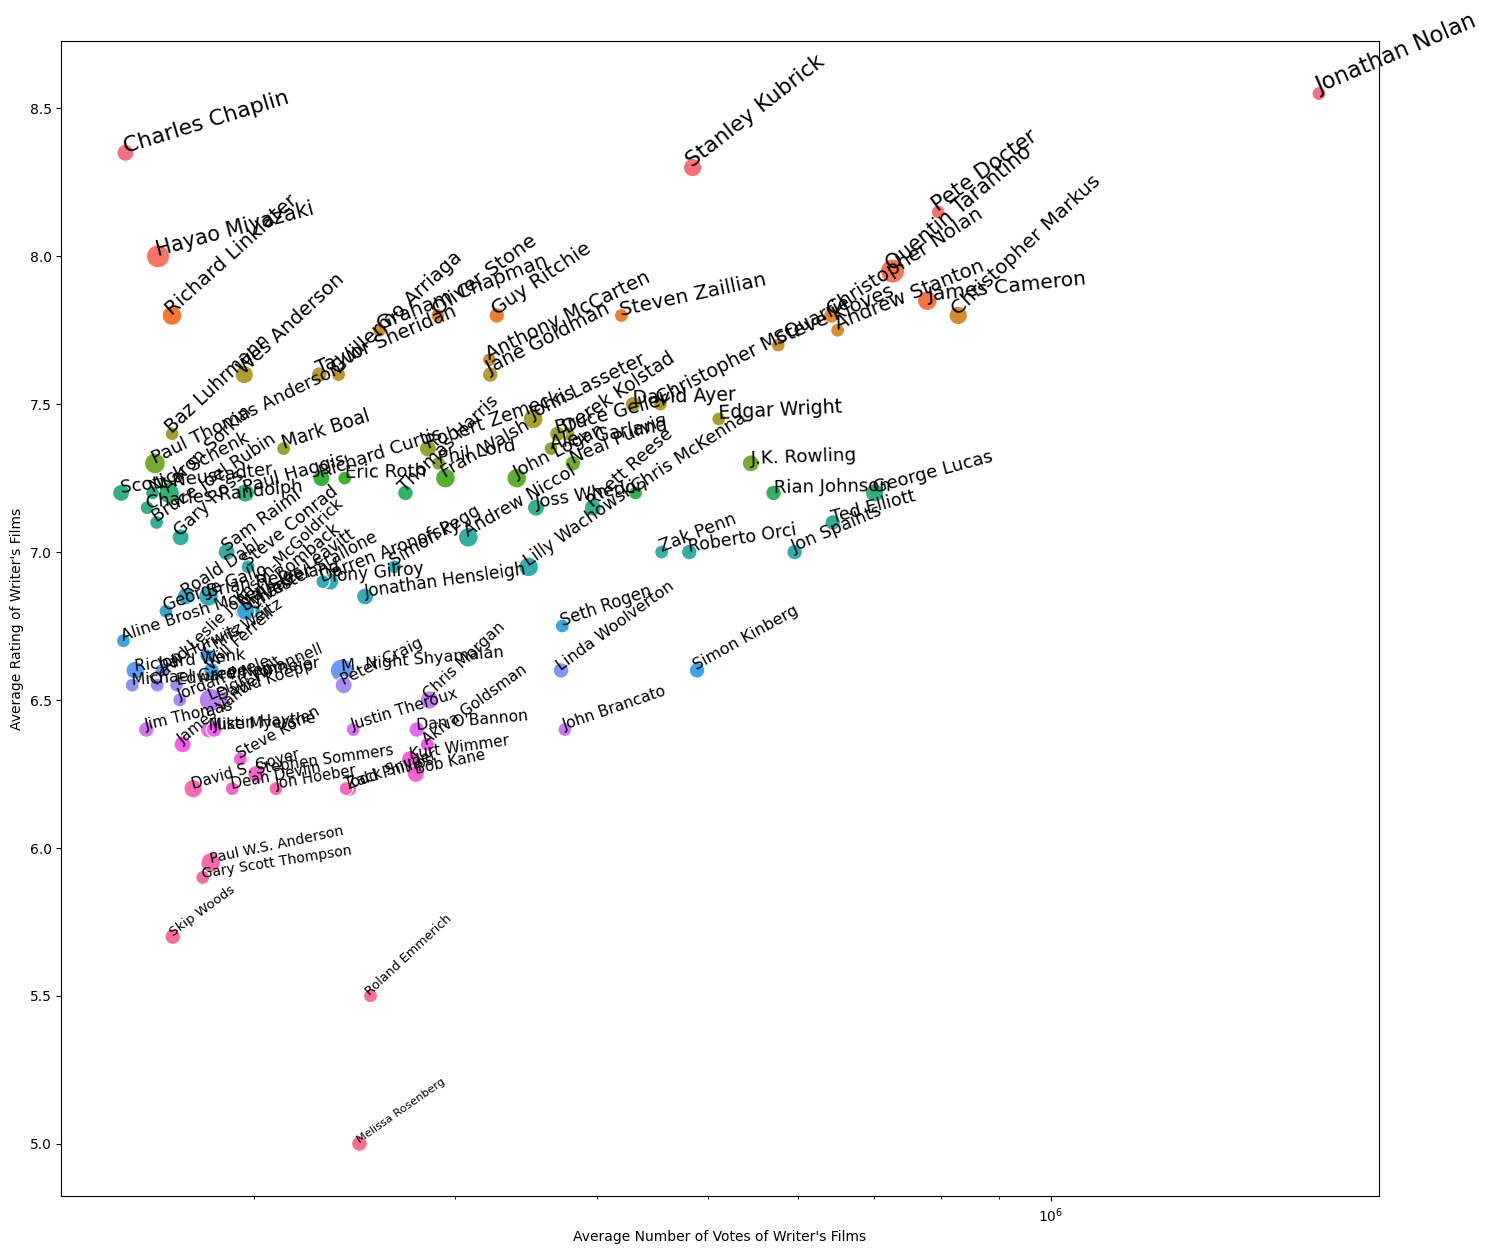

In [38]:
# Interesting that Jonathan Nolan is actually Chris Nolan's younger brother. After a little googling, I saw that he actually was co-writer for many of his brothers films. Also checked out Chris Markus and he wrote a lot of superhero films (popular).
# I included size in addition to color for success for clarity. This ultimately leads me to believe writers and directors may have colinearity but I would probably prefer director over writer in the final df.

writer_temp = name_ids.drop("directors",axis=1)
writer_temp.columns = ["tconst","nconst"]
writer_temp.nconst = writer_temp.nconst.dropna().apply(lambda x: x.split(",")[0])


writers = pd.merge(pd.merge(pd.merge(title_basics,ratings
                                     ,on="tconst")
                                    ,writer_temp,on="tconst")
                                    ,names_dir[["nconst","primaryName"]]
                                    ,on="nconst")

writer_success = writers[writers.numVotes>25000].groupby("primaryName").\
agg({"averageRating":[np.median],"numVotes":[np.median],"nconst":[np.size]}).\
sort_values(("averageRating","median"),ascending=False)


writers_successful = writer_success[(writer_success[("numVotes","median")]>150000)&\
                (writer_success[("nconst","size")]>=4)].sort_values(("averageRating","median"),ascending=False)


plt.figure(figsize=(17,15))
sns.scatterplot(y=writers_successful[("averageRating","median")],x=writers_successful[("numVotes","median")],
               s=writers_successful[("nconst","size")]*25,hue=writers_successful.index, legend=False,
               )
plt.xlabel("Average Number of Votes of Writer's Films")
plt.ylabel("Average Rating of Writer's Films")
plt.gca().set_xscale("log")

# same transpose and logscale as with directors
for names in writers_successful.T:
    plt.text(writers_successful.T[names][("numVotes","median")],
            writers_successful.T[names][("averageRating","median")],
             names,rotation=np.random.randint(0,45), rotation_mode="anchor",
             fontsize=writers_successful.T[names][("averageRating","median")]**1.3)
    
del writer_temp

In [39]:
# preparation to bring this data into existing dataframe

directors = directors[['tconst','primaryName']]
directors = directors.rename(columns={'primaryName': 'primaryDirector'})
writers = writers[['tconst', 'primaryName']]
writers = writers.rename(columns={'primaryName': 'primaryWriter'})

In [40]:
# merge writers and directors into existing dataframe
# naming this temp dataframe basic_ratings_dir_casi

basic_ratings_dir_casi = pd.merge(basic_ratings_dir, directors, on='tconst')
basic_ratings_dir_casi = pd.merge(basic_ratings_dir_casi, writers, on='tconst')

In [41]:
basic_ratings_dir_casi = basic_ratings_dir_casi.drop(['directors','writers'], axis=1)

In [42]:
basic_ratings_dir_casi.head()

tconst titleType                    primaryTitle  \
0  tt0000009     movie                      Miss Jerry   
1  tt0000502     movie                        Bohemios   
2  tt0000574     movie     The Story of the Kelly Gang   
3  tt0000591     movie                The Prodigal Son   
4  tt0000679     movie  The Fairylogue and Radio-Plays   

                    originalTitle  isAdult  startYear runtimeMinutes  \
0                      Miss Jerry        0       1894             45   
1                        Bohemios        0       1905            100   
2     The Story of the Kelly Gang        0       1906             70   
3               L'enfant prodigue        0       1907             90   
4  The Fairylogue and Radio-Plays        0       1908            120   

                       genres  averageRating  numVotes   primaryDirector  \
0                     Romance            5.3     198.0   Alexander Black   
1                         NaN            4.5      14.0  Ricardo de Baños   
2  Action,Adventure,Biography            6.0     778.0      Charles Tait   
3                       Drama            4.7      19.0      Michel Carré   
4           Adventure,Fantasy            5.3      66.0       Otis Turner   

      primaryWriter  
0   Alexander Black  
1  Ricardo de Baños  
2      Charles Tait  
3      Michel Carré  
4     L. Frank Baum

### 1.9 Explore genres

It turns out, genres are limited to a count of 3, and it's only the first 3 alphabetically. That is not reliable data to correctly classify genres.

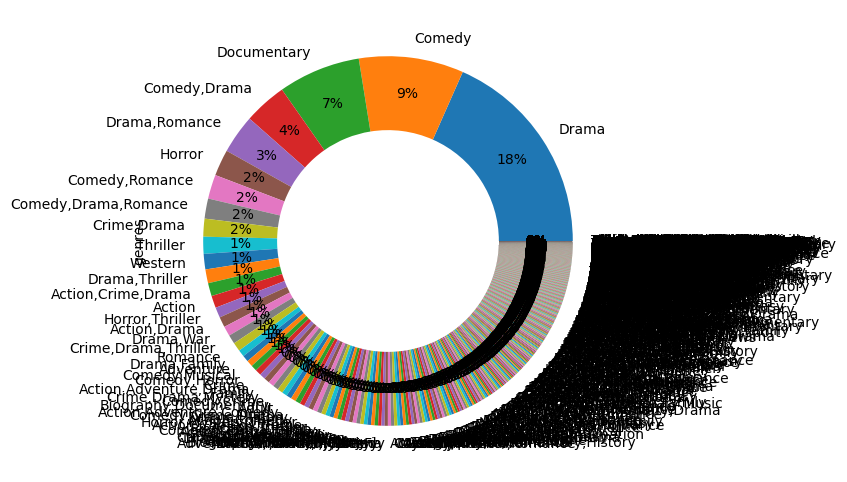

In [43]:
# genre analysis in this format is not legible

basic_ratings_dir_casi.genres.value_counts().plot.pie(autopct="%.0f%%",figsize=(6,6),pctdistance=0.8,wedgeprops=dict(width=0.4))
plt.show()

In [44]:
# Going to use Scikit-Learns CountVectorizer feature extraction to count each unique genre by converting to a matrix of token counts
# create a new column for each unique Genre title and it will be True/False if a movie has that genre or not

temp = basic_ratings_dir_casi.genres.dropna()
vec = CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b', analyzer='word').fit(temp)
bag_of_genres = vec.transform(temp)
unique_genres =  vec.get_feature_names_out()
np.array(unique_genres)

array(['action', 'adult', 'adventure', 'animation', 'biography', 'comedy',
       'crime', 'documentary', 'drama', 'family', 'fantasy', 'film-noir',
       'game-show', 'history', 'horror', 'music', 'musical', 'mystery',
       'news', 'reality-tv', 'romance', 'sci-fi', 'short', 'sport',
       'talk-show', 'thriller', 'war', 'western'], dtype=object)

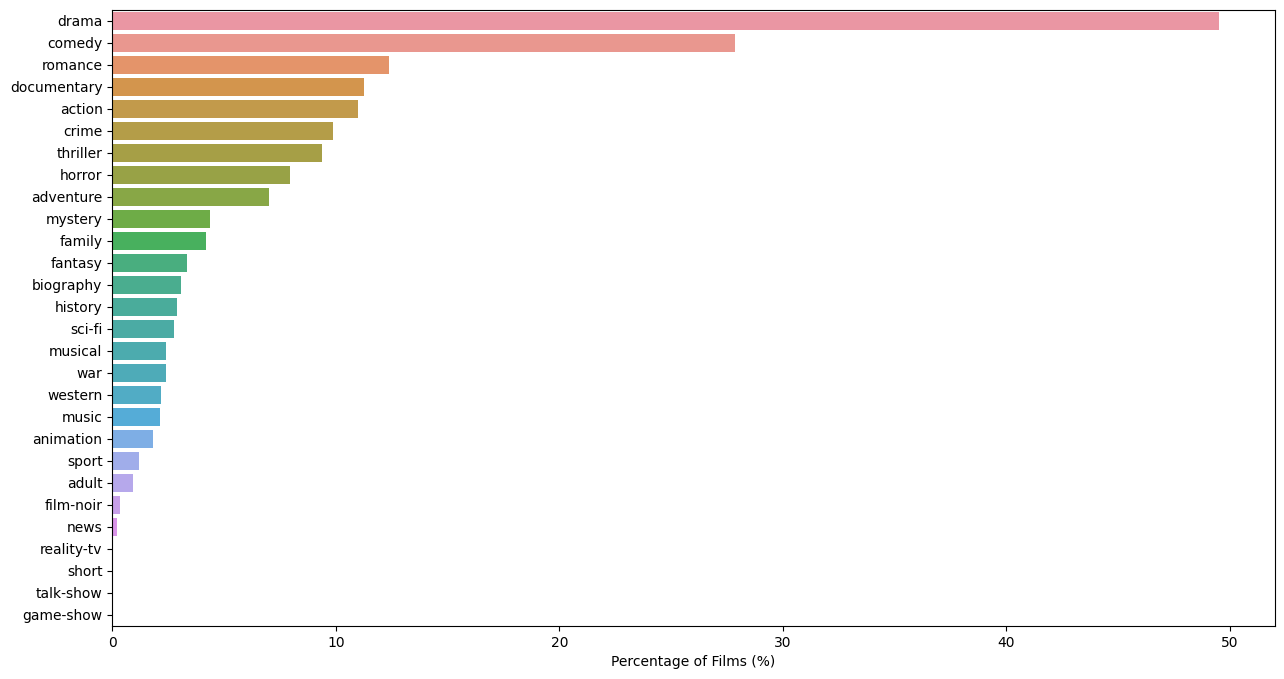

In [45]:
# important to note that because a movie can have multiple genres, their count will not be 100%

genres = pd.DataFrame(bag_of_genres.todense(),columns=unique_genres,index=temp.index)
sorted_genres_perc = 100*pd.Series(genres.sum()).sort_values(ascending=False)/genres.shape[0]
plt.figure(figsize=(15,8))
sns.barplot(x=sorted_genres_perc.values,y=sorted_genres_perc.index,orient="h")
plt.xlabel("Percentage of Films (%)")
plt.show()

In [46]:
# assign one genre based on lowest share assuming those with less share are more distinct
# regrouping into master genres

cols = ['genres', 'perc']
sorted_genres_perc_df = pd.Series.to_frame(sorted_genres_perc).reset_index(level=0)
sorted_genres_perc_df.columns = cols
sorted_genres_perc_df = sorted_genres_perc_df.sort_values(by='perc')

In [47]:
len(sorted_genres_perc_df.genres)

28

In [48]:
# checking for null values on genre

basic_ratings_dir_casi[basic_ratings_dir_casi['genres'].isna()].head()

tconst titleType        primaryTitle     originalTitle  isAdult  \
1   tt0000502     movie            Bohemios          Bohemios        0   
8   tt0001630     movie    Der fremde Vogel  Der fremde Vogel        0   
20  tt0002329     movie  Today and Tomorrow      Ma és holnap        0   
34  tt0002801     movie   The Black Diamond   Le diamant noir        0   
54  tt0003309     movie       Captive Souls          Rablélek        0   

    startYear runtimeMinutes genres  averageRating  numVotes  \
1        1905            100    NaN            4.5      14.0   
8        1911             45    NaN            6.2      29.0   
20       1912             41    NaN            5.0      33.0   
34       1913             50    NaN            5.6      23.0   
54       1914             99    NaN            4.8      28.0   

     primaryDirector     primaryWriter  
1   Ricardo de Baños  Ricardo de Baños  
8          Urban Gad         Urban Gad  
20    Michael Curtiz        Imre Roboz  
34     Alfred Machin     Alfred Machin  
54    Michael Curtiz       Imre Földes

In [49]:
# removing null values : imputing genre doesn't seem feasible or worthwhile

basic_ratings_dir_genre = basic_ratings_dir_casi[basic_ratings_dir_casi['genres'].notna()]
basic_ratings_dir_genre['genres'].isna().sum()

0

In [50]:
basic_ratings_dir_genre[basic_ratings_dir_genre['genres'].str.contains('Game')]

tconst titleType                   primaryTitle  \
177203  tt2896176     movie  Wait Wait Don't Tell Me Live!   
178915  tt3060698     movie               Treasure Hunters   

                        originalTitle  isAdult  startYear runtimeMinutes  \
177203  Wait Wait Don't Tell Me Live!        0       2013            130   
178915               Treasure Hunters        0       2015             85   

                            genres  averageRating  numVotes  \
177203                   Game-Show            8.9      11.0   
178915  Action,Adventure,Game-Show            3.3      61.0   

          primaryDirector    primaryWriter  
177203        David Stern      Doug Berman  
178915  Filip Maciejewicz  Berenika Bailey

In [51]:
basic_ratings_dir_genre[basic_ratings_dir_genre['genres'].isin(['Game-Show'])]

tconst titleType                   primaryTitle  \
177203  tt2896176     movie  Wait Wait Don't Tell Me Live!   

                        originalTitle  isAdult  startYear runtimeMinutes  \
177203  Wait Wait Don't Tell Me Live!        0       2013            130   

           genres  averageRating  numVotes primaryDirector primaryWriter  
177203  Game-Show            8.9      11.0     David Stern   Doug Berman

In [52]:
# hot fix for this one record to rename from game-show to drama

basic_ratings_dir_genre['genres'] = basic_ratings_dir_genre['genres'].replace({'Game-Show': 'Drama'})
basic_ratings_dir_genre[basic_ratings_dir_genre['genres'].isin(['Game-Show'])]

/tmp/ipykernel_18874/3216340440.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basic_ratings_dir_genre['genres'] = basic_ratings_dir_genre['genres'].replace({'Game-Show': 'Drama'})


Empty DataFrame
Columns: [tconst, titleType, primaryTitle, originalTitle, isAdult, startYear, runtimeMinutes, genres, averageRating, numVotes, primaryDirector, primaryWriter]
Index: []

In [53]:
# looking for movies where the genre is 'Talk-Show'

basic_ratings_dir_genre[basic_ratings_dir_genre['genres'].str.contains('Talk')]

tconst titleType  \
79030    tt0197821     movie   
135188  tt12312374     movie   
155418  tt16992574     movie   
165707  tt21108248     movie   
216316   tt7847324     movie   
219398   tt8479352     movie   

                                             primaryTitle  \
79030                      Revenge of the Motorcycle Mama   
135188          Oh no! The Rise of Skywalker was real bad   
155418           Jake Moss Tries to Explain His Paintings   
165707  Prince Oak Oakleyski Most Handsome in the Worl...   
216316                Ali & Cavett: The Tale of the Tapes   
219398          Bridging Heaven & Earth: Carlos Castaneda   

                                            originalTitle  isAdult  startYear  \
79030                      Revenge of the Motorcycle Mama        1       1972   
135188          Oh no! The Rise of Skywalker was real bad        0       2019   
155418           Jake Moss Tries to Explain His Paintings        0       2021   
165707  Prince Oak Oakleyski Most Handsome in the Worl...        0       2022   
216316                Ali & Cavett: The Tale of the Tapes        0       2018   
219398          Bridging Heaven & Earth: Carlos Castaneda        0       1995   

       runtimeMinutes                       genres  averageRating  numVotes  \
79030              55        Adult,Crime,Talk-Show            5.8      12.0   
135188             64                    Talk-Show            8.3      18.0   
155418             82                    Talk-Show            8.5       6.0   
165707             60        Comedy,News,Talk-Show            9.4      28.0   
216316             95  Documentary,Sport,Talk-Show            7.2     309.0   
219398             58                    Talk-Show            3.0       7.0   

             primaryDirector     primaryWriter  
79030            Basil Stark         Lou Plate  
135188       Jenny Nicholson   Jenny Nicholson  
155418             Jake Moss         Jake Moss  
165707  Prince Oak Oakleyski    Wanwisa Jaidee  
216316       Robert S. Bader   Robert S. Bader  
219398        Michael Martin  Carlos Castaneda

# Part 2: Feature Creation

#### 2.1 Filtering adult films

In [54]:
basic_ratings_dir_genre.loc[basic_ratings_dir_genre['isAdult'].eq(1)].sort_values(by='numVotes', ascending=False)

tconst titleType                                     primaryTitle  \
34667    tt0068468     movie                                      Deep Throat   
38060    tt0074113     movie  Alice in Wonderland: An X-Rated Musical Fantasy   
39996    tt0077415     movie                               Debbie Does Dallas   
33069    tt0065904     movie                    The Party at Kitty and Stud's   
34510    tt0068260     movie                            Behind the Green Door   
...            ...       ...                                              ...   
215701   tt7716142     movie                       Bouches fermées à défoncer   
196102   tt4885458     movie                                  Pretty in Black   
210595   tt6837240     movie                                         Job Site   
158566  tt18080290     movie                                     Acquaintance   
143852   tt1399101     movie               Ton ithele poly, olo kai pio mesa!   

                                          originalTitle  isAdult  startYear  \
34667                                       Deep Throat        1       1972   
38060   Alice in Wonderland: An X-Rated Musical Fantasy        1       1976   
39996                                Debbie Does Dallas        1       1978   
33069                     The Party at Kitty and Stud's        1       1970   
34510                             Behind the Green Door        1       1972   
...                                                 ...      ...        ...   
215701                       Bouches fermées à défoncer        1       1981   
196102                                  Pretty in Black        1       2000   
210595                                         Job Site        1       1984   
158566                                     Acquaintance        1       2020   
143852               Ton ithele poly, olo kai pio mesa!        1       1986   

       runtimeMinutes                genres  averageRating  numVotes  \
34667              61          Adult,Comedy            5.0    6776.0   
38060              88  Adult,Comedy,Fantasy            6.1    3011.0   
39996              80          Adult,Comedy            5.9    2910.0   
33069              71    Adult,Comedy,Drama            2.4    2357.0   
34510              72           Adult,Drama            5.8    2192.0   
...               ...                   ...            ...       ...   
215701             76                 Adult            3.4       5.0   
196102            104   Adult,Drama,Romance            6.8       5.0   
210595             88                 Adult            7.6       5.0   
158566             80                 Adult            6.6       5.0   
143852             90                 Adult            3.8       5.0   

        primaryDirector   primaryWriter  
34667    Gerard Damiano  Gerard Damiano  
38060      Bud Townsend   Bucky Searles  
39996       Jim Buckley  Maria Minestra  
33069   Morton M. Lewis    Milton Lewis  
34510      Jim Mitchell       Anonymous  
...                 ...             ...  
215701    Michel Caputo   Michel Caputo  
196102      Jürgen Wolf     Jürgen Wolf  
210595      Jim L. Ball    John Roberts  
158566      Richard Kim     Richard Kim  
143852     Nasos Spiris    Nasos Spiris  

[2156 rows x 12 columns]

In [55]:
# looking at adult film data based on genre name and isAdultFlag = 1

basic_ratings_dir_genre.loc[basic_ratings_dir_genre['genres'].str.contains('Adult') & basic_ratings_dir_genre['isAdult'].eq(1)]

tconst titleType                   primaryTitle  \
31328   tt0063176     movie                          Karla   
32726   tt0065397     movie     The Adult Workshop of Love   
32753   tt0065442     movie                     Bacchanale   
33069   tt0065904     movie  The Party at Kitty and Stud's   
33197   tt0066092     movie         Mona: The Virgin Nymph   
...           ...       ...                            ...   
218976  tt8391790     movie        Les Uns dans les autres   
221680  tt8996466     movie                     Landlocked   
221723  tt9005732     movie                       Brothers   
223893  tt9553136     movie            Thirteen Blue Doors   
224877  tt9811452     movie    Chikati Gadilo Chithakotudu   

                        originalTitle  isAdult  startYear runtimeMinutes  \
31328                           Karla        1       1969             80   
32726        Anatomie des Liebesaktes        1       1970             90   
32753                      Bacchanale        1       1970             70   
33069   The Party at Kitty and Stud's        1       1970             71   
33197          Mona: The Virgin Nymph        1       1970             71   
...                               ...      ...        ...            ...   
218976        Les Uns dans les autres        1       1981             72   
221680                     Landlocked        1       2018             49   
221723                       Brothers        1       1973             60   
223893            Thirteen Blue Doors        1       1971            104   
224877    Chikati Gadilo Chitakottudu        1       2019            152   

                      genres  averageRating  numVotes        primaryDirector  \
31328            Adult,Drama            5.3       8.0        Joseph W. Sarno   
32726                  Adult            5.8      14.0        Hermann Schnell   
32753   Adult,Fantasy,Horror            6.0     123.0             John Amero   
33069     Adult,Comedy,Drama            2.4    2357.0        Morton M. Lewis   
33197           Adult,Comedy            4.4     172.0           Howard Ziehm   
...                      ...            ...       ...                    ...   
218976                 Adult            3.6       5.0          Michel Caputo   
221680   Adult,Drama,Romance            6.1      58.0          Livia Cheibub   
221723                 Adult            7.8       8.0        Norman Yonemoto   
223893                 Adult            4.6       5.0         Terry Sullivan   
224877          Adult,Comedy            4.7      82.0  Santhosh P. Jayakumar   

                primaryWriter  
31328         Joseph W. Sarno  
32726         Hermann Schnell  
32753              John Amero  
33069            Milton Lewis  
33197           Bucky Searles  
...                       ...  
218976          Michel Caputo  
221680          Livia Cheibub  
221723        Norman Yonemoto  
223893          Margot Holtem  
224877  Santhosh P. Jayakumar  

[2026 rows x 12 columns]

In [56]:
# looking at adult film data based on genre name and isAdultFlag = 0

basic_ratings_dir_genre.loc[basic_ratings_dir_genre['genres'].str.contains('Adult') & basic_ratings_dir_genre['isAdult'].eq(0)].sort_values(by='numVotes', ascending=False)

tconst titleType  \
36085   tt0070696     movie   
39177   tt0075987     movie   
81177   tt0207195     movie   
37544   tt0073141     movie   
45123   tt0086409     movie   
74331   tt0179083     movie   
36296   tt0071103     movie   
93871   tt0285502     movie   
83664   tt0225011     movie   
92124   tt0275332     movie   
210678  tt6848590     movie   
184839  tt3590060     movie   
39158   tt0075955     movie   
221896  tt9036972     movie   
74204   tt0178605     movie   
97634   tt0311149     movie   
216999  tt7982798     movie   
145021  tt1423916     movie   
194487  tt4675846     movie   
111647  tt0442201     movie   
77681   tt0191791     movie   
218873  tt8374372     movie   
218918  tt8383018     movie   
218945  tt8386902     movie   
89655   tt0261194     movie   
75298   tt0182358     movie   
218975  tt8391724     movie   
217000  tt7982976     movie   
218883  tt8375972     movie   
218930  tt8384636     movie   
218878  tt8375040     movie   

                                             primaryTitle  \
36085                                    The Sinful Dwarf   
39177                          Emanuelle Around the World   
81177            Wadd: The Life & Times of John C. Holmes   
37544                           In the Sign of the Gemini   
45123                               Taking Tiger Mountain   
74331        Aphrodisiac!: The Sexual Secret of Marijuana   
36296                                Perverse Adolescence   
93871                   Female Beautician Rope Discipline   
83664                             Oh! Woman: A Dirty Song   
92124                            Erótica, a Fêmea Sensual   
210678                       Moonshine Meat Market Mayhem   
184839                                  A Clock Work Blue   
39158                        The Double Exposure of Holly   
221896                               Poland's Gay Shocker   
74204                                  Les petites garces   
97634                                        Fome de Sexo   
216999                     Secrétaires très particulières   
145021                               Champion: Love Hurts   
194487                                           Snapshot   
111647                                Em Busca do Orgasmo   
77681                              Aristocratica perversa   
218873                               Super Sexual Fantasy   
218918                      L'ouvreuse n'a pas de culotte   
218945        Plaisirs sodomites pour salopes inassouvies   
89655                                    O Prazer do Sexo   
75298                 La parte più appetitosa del maschio   
218975                         Une si jolie petite chatte   
217000  Adolescentes brûlantes pour soirées très spéci...   
218883                 Je suis vicieuse mais je me soigne   
218930                             Les petites allumeuses   
218878                  Goûts pervers d'une femme soumise   

                                            originalTitle  isAdult  startYear  \
36085                                             Dværgen        0       1973   
39177             Emanuelle - Perché violenza alle donne?        0       1977   
81177            Wadd: The Life & Times of John C. Holmes        0       1999   
37544                                I Tvillingernes tegn        0       1975   
45123                               Taking Tiger Mountain        0       1983   
74331        Aphrodisiac!: The Sexual Secret of Marijuana        0       1971   
36296                               Adolescence pervertie        0       1974   
93871                 Dan Oniroku onna biyoshi nawa shiku        0       1981   
83664                                 A! Onnatachi: Waika        0       1981   
92124                            Erótica, a Fêmea Sensual        0       1984   
210678                       Moonshine Meat Market Mayhem        0       2016   
184839                                  A Clock Work Blue        0       1972   
39158       

In [57]:
# removing adult films based on isAdult flag

basic_ratings_dir_genre = basic_ratings_dir_genre[basic_ratings_dir_genre.isAdult == 0] 

In [58]:
# removing adult films based on genre name

basic_ratings_dir_genre = basic_ratings_dir_genre[basic_ratings_dir_genre['genres'].str.contains('Adult')==False] 

### 2.2 Creating Master Genres

In [59]:
# Scikit-Learns CountVectorizer again to view share of genre in the data

temp = basic_ratings_dir_genre.genres.dropna()
vec = CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b', analyzer='word').fit(temp)
bag_of_genres = vec.transform(temp)
unique_genres =  vec.get_feature_names_out()
genres = pd.DataFrame(bag_of_genres.todense(),columns=unique_genres,index=temp.index)
sorted_genres_perc = 100*pd.Series(genres.sum()).sort_values(ascending=False)/genres.shape[0]

In [60]:
cols = ['genres', 'perc']
sorted_genres_perc_df = pd.Series.to_frame(sorted_genres_perc).reset_index(level=0)
sorted_genres_perc_df.columns = cols
sorted_genres_perc_df = sorted_genres_perc_df.sort_values(by='perc')

In [61]:
sorted_genres_perc_df.genres

26      game-show
25      talk-show
24          short
23     reality-tv
22           news
21      film-noir
20          sport
19      animation
18          music
17        western
16            war
15        musical
14         sci-fi
13        history
12      biography
11        fantasy
10         family
9         mystery
8       adventure
7          horror
6        thriller
5           crime
4          action
3     documentary
2         romance
1          comedy
0           drama
Name: genres, dtype: object

In [62]:
# used this to test lots of genres to see if they were unique (e.g. game-show listed as the only genre for a movie or if it is combined with others that can be grouped in a case statement)

basic_ratings_dir_genre[basic_ratings_dir_genre['genres'].str.contains('Short')].sort_values(by='numVotes', ascending=False)

tconst titleType               primaryTitle  \
75982    tt0184773     movie           The Nazis Strike   
110675   tt0431405     movie          Sleeping Dogs Lie   
212554   tt7177596     movie                      Maxxx   
224258   tt9649326     movie    Roofied 4: The Antidote   
151885  tt15825552     movie                       Mudi   
96641    tt0303241     movie                A Worn Path   
93394    tt0282644     movie     Journey to the Pacific   
159140   tt1826609     movie                  Bad Blood   
206351   tt6166464     movie               Amanda McKay   
191262   tt4257908     movie  Lady Ganga: Nilza's Story   
134049   tt1204962     movie       Scenes from Oblivion   
82994    tt0219179     movie             Mint Condition   
191971   tt4345626     movie            Sterling Silver   

                    originalTitle  isAdult  startYear runtimeMinutes  \
75982            The Nazis Strike        0       1943             41   
110675          Sleeping Dogs Lie        0       2005             25   
212554                      Maxxx        0       2017              6   
224258    Roofied 4: The Antidote        0       2019             44   
151885                       Mudi        0       2021             43   
96641                 A Worn Path        0       1994             22   
93394      Journey to the Pacific        0       1968             43   
159140                  Bad Blood        0       2011             10   
206351               Amanda McKay        0       2018             33   
191262  Lady Ganga: Nilza's Story        0       2015             15   
134049       Scenes from Oblivion        0       2008             30   
82994              Mint Condition        0       2001             18   
191971            Sterling Silver        0       2015              6   

                           genres  averageRating  numVotes   primaryDirector  \
75982   Documentary,History,Short            7.0     860.0    Anatole Litvak   
110675        Drama,Mystery,Short            6.2     199.0    Stuart Lessner   
212554               Comedy,Short            7.7     129.0      O-T Fagbenle   
224258         Action,Crime,Short            1.2      84.0        Sammie Lei   
151885                Drama,Short            8.8      57.0    Yassir Muhamed   
96641                 Drama,Short            6.8      34.0    Bruce Schwartz   
93394           Documentary,Short            4.4      29.0    Gary Goldsmith   
159140                Drama,Short            7.5      25.0     Michael Yebba   
206351                Drama,Short            8.1      25.0        Mark Haber   
191262          Documentary,Short            8.6      17.0  Frederic Lumiere   
134049         Comedy,Drama,Short            6.4      12.0       Mike Cuenca   
82994         Action,Comedy,Short            7.2       9.0  Ashby Richardson   
191971                Drama,Short            7.2       8.0   Brian K. Palmer   

            primaryWriter  
75982   Julius J. Epstein  
110675     Chumahan Bowen  
212554       O-T Fagbenle  
224258         Sammie Lei  
151885          Hashir K.  
96641      Bruce Schwartz  
93394      Gary Goldsmith  
159140      Michael Yebba  
206351         Mark Haber  
191262         Mark Hefti  
134049        Mike Cuenca  
82994    Ashby Richardson  
191971    Brian K. Palmer

In [63]:
basic_ratings_dir_genre[basic_ratings_dir_genre['genres'] == 'Short'].sort_values(by='numVotes', ascending=False)

Empty DataFrame
Columns: [tconst, titleType, primaryTitle, originalTitle, isAdult, startYear, runtimeMinutes, genres, averageRating, numVotes, primaryDirector, primaryWriter]
Index: []

In [64]:
# creating new genre feature by grouping similar genres into master genre. Sorting them by "uniqueness" and
# share of genre within dataset with assumption that the more distinct the genre the more useful of a feature it will be
# will likely have to hot encode this later

musical = ['Music', 'Musical']
sport = ['Sport']
documentary = ['Documentary', 'News', 'History', 'Talk-Show', 'Reality-TV', 'History', 'Biography']
war = ['War']
western = ['Western']
action = ['Action']
adventure = ['Adventure']
sciFiFantasy = ['Sci-Fi', 'Fantasy', 'Animation']
horrorThriller = ['Horror', 'Thriller']
crime = ['Crime', 'Mystery', 'Film-Noir']
family = ['Family']
romance = ['Romance']
comedy = ['Comedy']
drama = ['Drama']


basic_ratings_dir_genre['masterGenres'] = np.where(basic_ratings_dir_genre['genres'].str.contains('|'.join(musical)), 'Musical',
                                                   np.where(basic_ratings_dir_genre['genres'].str.contains('|'.join(sport)), 'Sport',
                                                   np.where(basic_ratings_dir_genre['genres'].str.contains('|'.join(adventure)), 'Adventure',
                                                   np.where(basic_ratings_dir_genre['genres'].str.contains('|'.join(action)), 'Action',
                                                   np.where(basic_ratings_dir_genre['genres'].str.contains('|'.join(documentary)), 'Documentary/Historical',
                                                   np.where(basic_ratings_dir_genre['genres'].str.contains('|'.join(war)), 'War',
                                                   np.where(basic_ratings_dir_genre['genres'].str.contains('|'.join(western)), 'Western',
                                                   np.where(basic_ratings_dir_genre['genres'].str.contains('|'.join(sciFiFantasy)), 'Sci-Fi/Fantasy',
                                                   np.where(basic_ratings_dir_genre['genres'].str.contains('|'.join(horrorThriller)), 'Horror/Thriller',
                                                   np.where(basic_ratings_dir_genre['genres'].str.contains('|'.join(crime)), 'Crime/Mystery',
                                                   np.where(basic_ratings_dir_genre['genres'].str.contains('|'.join(family)), 'Family',
                                                   np.where(basic_ratings_dir_genre['genres'].str.contains('|'.join(romance)), 'Romance',
                                                   np.where(basic_ratings_dir_genre['genres'].str.contains('|'.join(comedy)), 'Comedy',
                                                   np.where(basic_ratings_dir_genre['genres'].str.contains('|'.join(drama)), 'Drama', 'other'))))))))))))))

In [65]:
basic_ratings_dir_genre[basic_ratings_dir_genre['masterGenres'] == 'other']

Empty DataFrame
Columns: [tconst, titleType, primaryTitle, originalTitle, isAdult, startYear, runtimeMinutes, genres, averageRating, numVotes, primaryDirector, primaryWriter, masterGenres]
Index: []

### 2.2 Visualizing Master Genres

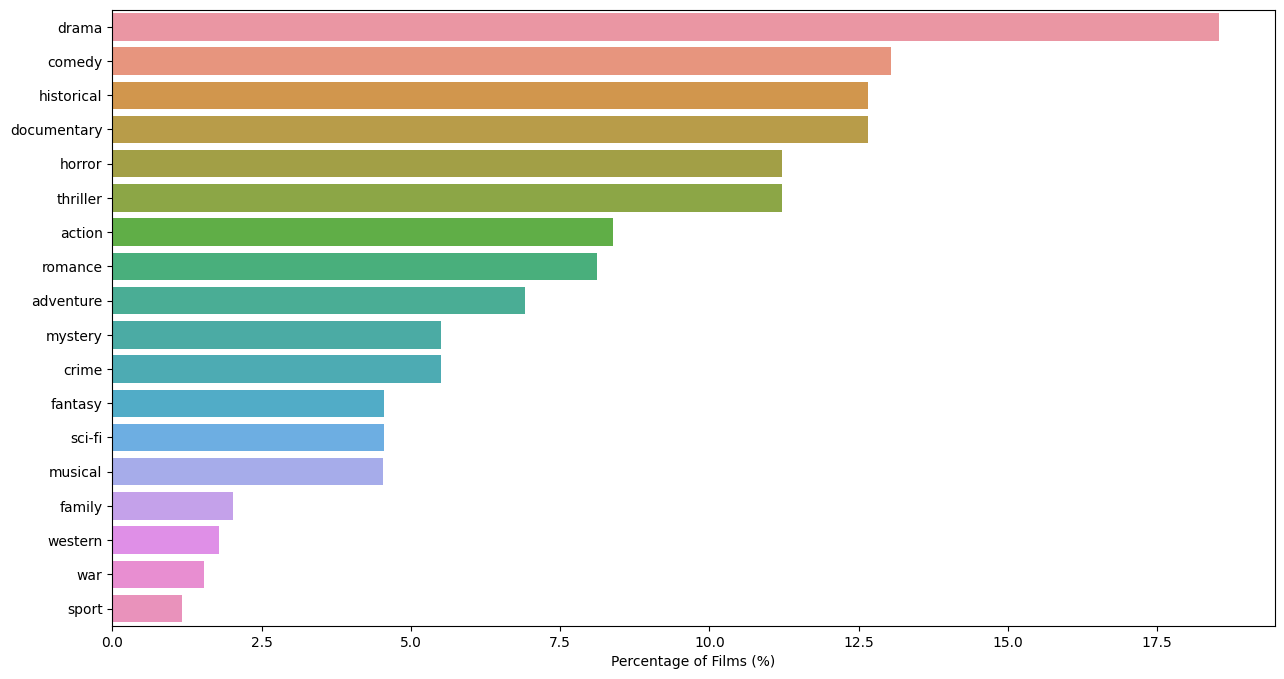

In [66]:
# visualize genre

temp = basic_ratings_dir_genre.masterGenres.dropna()
vec = CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b', analyzer='word').fit(temp)
bag_of_genres = vec.transform(temp)
unique_genres =  vec.get_feature_names_out()
genres = pd.DataFrame(bag_of_genres.todense(),columns=unique_genres,index=temp.index)
sorted_genres_perc = 100*pd.Series(genres.sum()).sort_values(ascending=False)/genres.shape[0]
plt.figure(figsize=(15,8))
sns.barplot(x=sorted_genres_perc.values,y=sorted_genres_perc.index,orient="h")
plt.xlabel("Percentage of Films (%)")
plt.show()

### 2.3 Number of votes feature filtering

In [67]:
# Want to look at votes per year in combination with average rating over time to see if we can identify any historical trend

counts_yearly = basic_ratings_dir_genre.groupby("startYear").agg({"averageRating":[np.median], "numVotes":[np.sum,np.size,lambda x: np.sum(x)/np.size(x)]})
max_count_year = counts_yearly[("numVotes","sum")].idxmax().astype(int)
max_year = counts_yearly[("numVotes","size")].idxmax().astype(int)

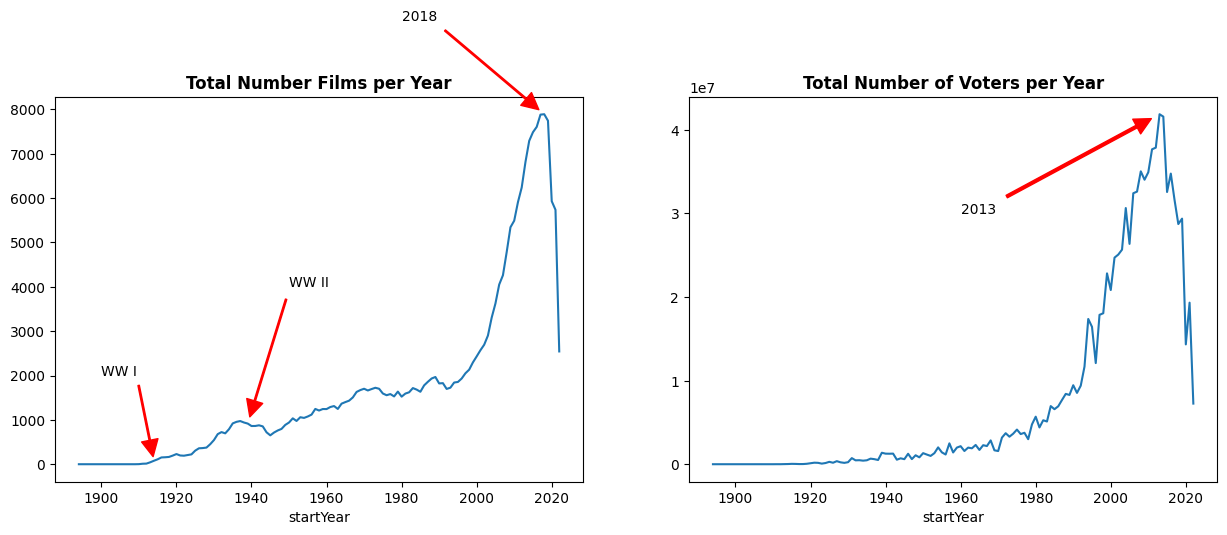

In [68]:
# plot on left shows number of films created per year, right shows number of voters for films made at the corresponding year
# votes peaked in 2013 then had a steep decline but the number of films pade per year increases until 2018 -- interesting. Is this because quality of films decreased? 

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ax =counts_yearly[("numVotes","size")].plot()
ax.annotate(max_year,xy=(max_year,counts_yearly[("numVotes","size")].max())
            , xytext=(1980,10000)
            , arrowprops=dict(color="red",shrink=0.05,width=1))
ax.annotate("WW I",xy=(1914,counts_yearly[("numVotes","size")].loc[1914])
            , xytext=(1900,2000)
            , arrowprops=dict(color="red",shrink=0.05,width=1))
ax.annotate("WW II",xy=(1939,counts_yearly[("numVotes","size")].loc[1939])
            , xytext=(1950,4000)
            , arrowprops=dict(color="red",shrink=0.05,width=1))
plt.title("Total Number Films per Year",fontweight="bold")


plt.subplot(1,2,2)
ax =counts_yearly[("numVotes","sum")].plot()
ax.annotate(max_count_year,xy=(max_count_year,counts_yearly[("numVotes","sum")].max())
            , xytext=(1960,3e7)
            , arrowprops=dict(shrink=0.05,color="red",width=2))
plt.title("Total Number of Voters per Year",fontweight="bold")
plt.show()

In [69]:
max_count_year_per_film = counts_yearly[("numVotes","<lambda_0>")].idxmax().astype(int)

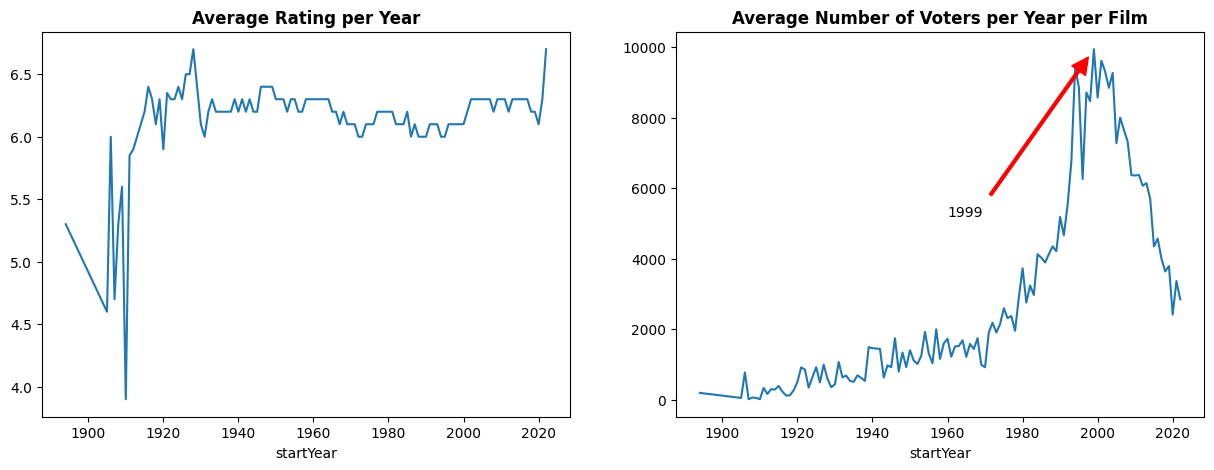

In [70]:
# left plot shows average rating of films per year, right shows average voters per film on a yearly basis
# since the 20s, average ratings did a sideways pattern in a bounded range until recently with a large spike in 2020s
# voters peaked in the late 90s and early 2000s  then decreased. This could be related to the age group of imdb voters at that time and engagement with imdb.


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ax =counts_yearly[("averageRating","median")].plot()
plt.title("Average Rating per Year",fontweight="bold")



plt.subplot(1,2,2)
ax = counts_yearly[("numVotes","<lambda_0>")].plot()
ax.annotate(max_count_year_per_film,xy=(max_count_year_per_film,counts_yearly[("numVotes","<lambda_0>")].max())
            , xytext=(1960,5200)
            , arrowprops=dict(shrink=0.05,color="red",width=2))
plt.title("Average Number of Voters per Year per Film",fontweight="bold")
plt.show()

### 2.4 Runtime feature filtering

/home/creeg/projects/audible/venv/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


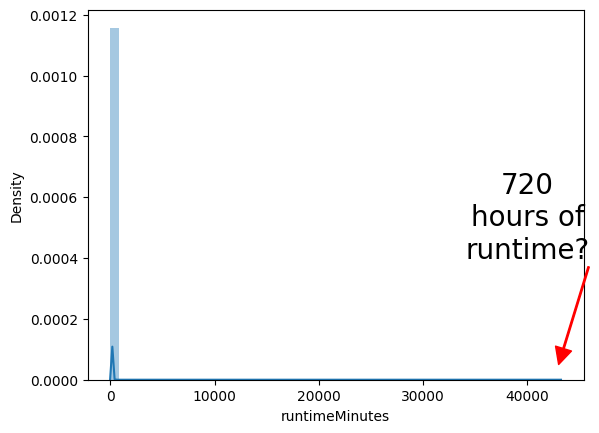

In [71]:
# runtime in minutes

sns.distplot(basic_ratings_dir_genre.runtimeMinutes.dropna().astype(int),bins=50)

plt.gca().annotate("720\nhours of\nruntime?"
                   , xy=(43000,0.00005)
                   , xytext=(40000,0.0004)
                   , fontsize=20, ha="center"
                   , arrowprops=dict(color="red",width=1))
plt.show()


In [72]:
# Very long documentary

runtime = basic_ratings_dir_genre[basic_ratings_dir_genre.runtimeMinutes.notnull()]
runtime['runtimeMinutes'] = runtime.runtimeMinutes.astype(int)
runtime[runtime.runtimeMinutes>40000]

tconst titleType primaryTitle originalTitle  isAdult  startYear  \
187648  tt3854496     movie     Ambiancé      Ambiancé        0       2020   

        runtimeMinutes       genres  averageRating  numVotes primaryDirector  \
187648           43200  Documentary            4.7      98.0   Anders Weberg   

        primaryWriter            masterGenres  
187648  Anders Weberg  Documentary/Historical

In [73]:
# need to remove outliers to see clear distribution 

runtime.sort_values(by='runtimeMinutes', ascending=False).head()

tconst titleType           primaryTitle          originalTitle  \
187648   tt3854496     movie               Ambiancé               Ambiancé   
127575  tt10844900     movie                     Qw                     Qw   
93644    tt0284020     movie  The Cure for Insomnia  The Cure for Insomnia   
74367    tt0179184     movie                   ****                   ****   
146179   tt1447786     movie     Grandmother Martha     Grandmother Martha   

        isAdult  startYear  runtimeMinutes             genres  averageRating  \
187648        0       2020           43200        Documentary            4.7   
127575        0       2019           10062              Drama            7.3   
93644         0       1987            5220  Documentary,Music            4.9   
74367         0       1967            1500              Drama            6.4   
146179        0       1996            1452        Documentary            8.2   

        numVotes       primaryDirector  primaryWriter            masterGenres  
187648      98.0         Anders Weberg  Anders Weberg  Documentary/Historical  
127575      31.0        Ibrahim Hamdan   Marco Romano                   Drama  
93644      379.0  John Henry Timmis IV    L.D. Groban                 Musical  
74367       96.0           Andy Warhol    Andy Warhol                   Drama  
146179       9.0           Sydney Ling    Sydney Ling  Documentary/Historical

/home/creeg/projects/audible/venv/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/creeg/projects/audible/venv/lib/python3.10/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 10 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


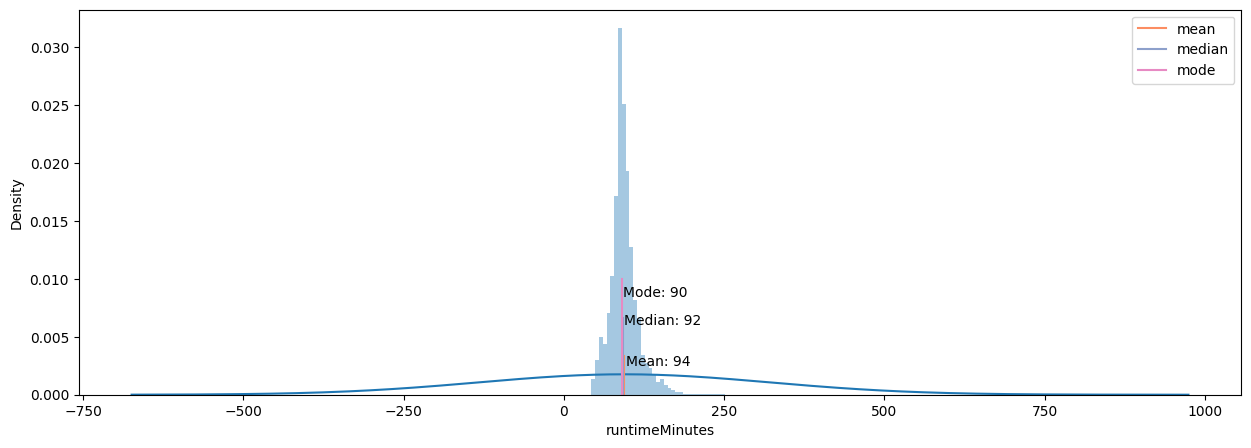

In [74]:
# normal distribution centered around 90

runtime = runtime.runtimeMinutes[runtime.runtimeMinutes<300]
mean_rt, median_rt, mode_rt = runtime.mean(), runtime.median(), runtime.mode() [0]

plt.figure(figsize=(15,5))
sns.distplot(runtime,kde_kws=dict(bw=10))
plt.gca().axvline(mean_rt,label="mean",color=sns.color_palette("Set2")[1],ymax=0.1)
plt.gca().axvline(median_rt,label="median",color=sns.color_palette("Set2")[2],ymax=0.2)
plt.gca().axvline(mode_rt,label="mode",color=sns.color_palette("Set2")[3],ymax=0.3)
plt.text(mean_rt+2,0.0025,f"Mean: {int(mean_rt)}")
plt.text(median_rt+2,0.006,f"Median: {int(median_rt)}")
plt.text(mode_rt+2,0.0085,f"Mode: {int(mode_rt)}")
plt.legend()
plt.show()

In [75]:
del runtime, median_rt, mean_rt, mode_rt

### 2.4 Movie cast features
* This data contains principal cast/crew for titles

In [76]:
# this will give us principal cast & crew

principals = pd.read_csv('/home/creeg/projects/audible/imdb_data/title.principals.tsv.gz'
                           , sep='\t'
                           , low_memory=False
                           , na_values = ["\\N","nan"])

: 

: 

<AxesSubplot:ylabel='category'>

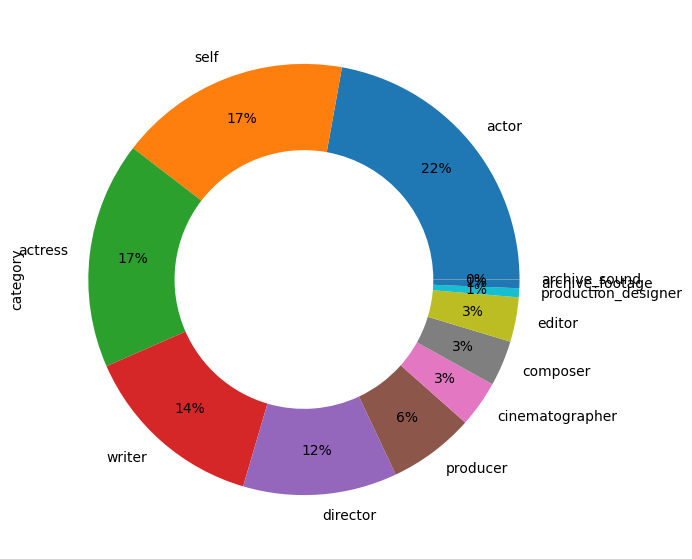

In [ ]:
# not surprising that almost 1 out of every 3 members of the cast are actor/actress
# will be grouping actor and actress into one category since "actor" can now be used interchangably for any gender

principals.category.value_counts().plot.pie(autopct="%.0f%%"
                                            , pctdistance=0.8
                                            , figsize=(7,7)
                                            , wedgeprops=dict(width=0.4))

In [ ]:
# time to find out who has been working the most in the movie industry!
# Ilaiyaraaja and Shoji Saki are the contributors with the highest numbers AND Brahmanandam was involved in almost 800 films as an actor.

inxs = principals.tconst.isin(title_basics.tconst)
use = principals[inxs]
top_names = use.nconst.value_counts().head(20)
top_names = pd.DataFrame(list(zip(top_names.index,top_names.values)),columns=["nconst","count"])
top_names = pd.merge(top_names,names_dir[["nconst","primaryName"]],on="nconst")
top_names["job_type"] = [use[use["nconst"] == i].category.value_counts().index[0] for i in top_names.nconst]
top_names

nconst  count                   primaryName  job_type
0   nm0006137   1007                   Ilaiyaraaja  composer
1   nm0756966   1000                   Shôji Sakai    editor
2   nm0103977    786                  Brahmanandam     actor
3   nm0000636    569           William Shakespeare    writer
4   nm0648803    563              Matsunosuke Onoe     actor
5   nm0006982    552                   Adoor Bhasi     actor
6   nm0305182    547                  Eddie Garcia     actor
7   nm0232490    515               Dong-Chun Hyeon    editor
8   nm0453459    511                    Hui-su Kim    editor
9   nm1930572    484                 Kevin MacLeod  composer
10  nm0481568    482                  Bappi Lahiri  composer
11  nm0706691    472                   Sultan Rahi     actor
12  nm0473742    469  Laxmikant Shantaram Kudalkar  composer
13  nm0644554    444                   Kinya Ogawa  director
14  nm0619107    427              Masayoshi Nogami     actor
15  nm0793813    406                  Sung-il Shin     actor
16  nm0156963    405             Hsing-Lung Chiang    editor
17  nm0183659    404                Gérard Courant  director
18  nm0046850    400                       Bahadur     actor
19  nm0246703    397                  Paquito Diaz     actor

In [ ]:
len(principals)

51463414

In [ ]:
# filter principals data what we have in existing dataframe

principals= principals[principals.tconst.isin(basic_ratings_dir_genre.tconst.unique())]
len(principals)

2020040

In [ ]:
principals.category.unique()

array(['actress', 'actor', 'director', 'cinematographer', 'producer',
       'composer', 'writer', 'production_designer', 'editor', 'self',
       'archive_footage', 'archive_sound'], dtype=object)

In [ ]:
principals.head()

tconst  ordering     nconst         category  \
24    tt0000009         1  nm0063086          actress   
25    tt0000009         2  nm0183823            actor   
26    tt0000009         3  nm1309758            actor   
27    tt0000009         4  nm0085156         director   
1042  tt0000574        10  nm0675239  cinematographer   

                          job  \
24                        NaN   
25                        NaN   
26                        NaN   
27                        NaN   
1042  director of photography   

                                             characters  
24             ["Miss Geraldine Holbrook (Miss Jerry)"]  
25                                     ["Mr. Hamilton"]  
26    ["Chauncey Depew - the Director of the New Yor...  
27                                                  NaN  
1042                                                NaN

In [ ]:
principals = principals.drop(['ordering', 'job', 'characters'], axis=1)

In [ ]:
# bring in name of crew

principals = pd.merge(principals, names_dir[['nconst','primaryName']], on=['nconst'])
principals.head()

tconst     nconst category        primaryName
0  tt0000009  nm0063086  actress    Blanche Bayliss
1  tt0000009  nm0183823    actor  William Courtenay
2  tt0019859  nm0183823    actor  William Courtenay
3  tt0020403  nm0183823    actor  William Courtenay
4  tt0000009  nm1309758    actor     Chauncey Depew

In [ ]:
principals.isna().sum().sum()

0

In [ ]:
principals = principals.drop(['nconst'], axis=1)

In [ ]:
principals.head()

tconst category        primaryName
0  tt0000009  actress    Blanche Bayliss
1  tt0000009    actor  William Courtenay
2  tt0019859    actor  William Courtenay
3  tt0020403    actor  William Courtenay
4  tt0000009    actor     Chauncey Depew

In [ ]:
principals['category'] = principals['category'].replace(['actress'], 'actor')

In [ ]:
principals.head()

tconst category        primaryName
0  tt0000009    actor    Blanche Bayliss
1  tt0000009    actor  William Courtenay
2  tt0019859    actor  William Courtenay
3  tt0020403    actor  William Courtenay
4  tt0000009    actor     Chauncey Depew

In [ ]:
principals.category.unique()

array(['actor', 'director', 'cinematographer', 'producer', 'composer',
       'writer', 'archive_footage', 'production_designer', 'editor',
       'self', 'archive_sound'], dtype=object)

In [ ]:
principals.groupby(['tconst', 'category'])['category'].count()

tconst     category       
tt0000009  actor              3
           director           1
tt0000574  actor              4
           cinematographer    1
           composer           1
                             ..
tt9916538  actor              4
           composer           1
           director           1
           producer           1
           writer             3
Name: category, Length: 1092551, dtype: int64

In [ ]:
principals['category'] = principals.category + principals.groupby(['tconst', 'category']).cumcount().astype(str).replace(r'^0$', '', regex=True)
principals.head()

tconst category        primaryName
0  tt0000009    actor    Blanche Bayliss
1  tt0000009   actor1  William Courtenay
2  tt0019859    actor  William Courtenay
3  tt0020403    actor  William Courtenay
4  tt0000009   actor2     Chauncey Depew

In [ ]:
# get entire cast per movie

principals = principals.pivot(index='tconst', columns='category', values='primaryName').reset_index()
principals.head()

category     tconst            actor                        actor1  \
0         tt0000009  Blanche Bayliss             William Courtenay   
1         tt0000574   Elizabeth Tait                     John Tait   
2         tt0000591    Georges Wague                  Henri Gouget   
3         tt0000679    L. Frank Baum                   Frank Burns   
4         tt0001184   Dolores Puchol  Cecilio Rodríguez de la Vega   

category               actor2             actor3 actor4 actor5 actor6 actor7  \
0              Chauncey Depew                NaN    NaN    NaN    NaN    NaN   
1           Nicholas Brierley    Norman Campbell    NaN    NaN    NaN    NaN   
2         Christiane Mandelys     Gilberte Sergy    NaN    NaN    NaN    NaN   
3            George E. Wilson  Wallace Illington    NaN    NaN    NaN    NaN   
4                         NaN                NaN    NaN    NaN    NaN    NaN   

category actor8  ... self9           writer writer1 writer2 writer3 writer4  \
0           NaN  ...   NaN              NaN     NaN     NaN     NaN     NaN   
1           NaN  ...   NaN              NaN     NaN     NaN     NaN     NaN   
2           NaN  ...   NaN              NaN     NaN     NaN     NaN     NaN   
3           NaN  ...   NaN              NaN     NaN     NaN     NaN     NaN   
4           NaN  ...   NaN  Víctor Balaguer     NaN     NaN     NaN     NaN   

category writer5 writer6 writer7 writer8  
0            NaN     NaN     NaN     NaN  
1            NaN     NaN     NaN     NaN  
2            NaN     NaN     NaN     NaN  
3            NaN     NaN     NaN     NaN  
4            NaN     NaN     NaN     NaN  

[5 rows x 93 columns]

In [ ]:
percent_missing = principals.isnull().sum() * 100 / len(principals)
missing_value_principals = pd.DataFrame({'column_name': principals.columns, 'percent_missing': percent_missing})
missing_value_principals.sort_values(by='percent_missing', inplace=True, ascending=False)
missing_value_principals

column_name  percent_missing
category                                           
writer8                    writer8        99.999542
archive_sound4      archive_sound4        99.999542
producer8                producer8        99.999542
cinematographer7  cinematographer7        99.999542
archive_sound6      archive_sound6        99.999542
...                            ...              ...
actor2                      actor2        11.290374
actor1                      actor1        10.000687
actor                        actor         8.006410
director                  director         5.641753
tconst                      tconst         0.000000

[93 rows x 2 columns]

In [ ]:
del percent_missing, missing_value_principals

In [ ]:
# delete columns that have 60% or more null

principals = principals.dropna(thresh=principals.shape[0]*.6, how='all', axis=1)
principals.head()

category     tconst            actor                        actor1  \
0         tt0000009  Blanche Bayliss             William Courtenay   
1         tt0000574   Elizabeth Tait                     John Tait   
2         tt0000591    Georges Wague                  Henri Gouget   
3         tt0000679    L. Frank Baum                   Frank Burns   
4         tt0001184   Dolores Puchol  Cecilio Rodríguez de la Vega   

category               actor2             actor3 cinematographer  \
0              Chauncey Depew                NaN             NaN   
1           Nicholas Brierley    Norman Campbell     Orrie Perry   
2         Christiane Mandelys     Gilberte Sergy             NaN   
3            George E. Wilson  Wallace Illington             NaN   
4                         NaN                NaN  Ramón de Baños   

category           composer          director     producer           writer  
0                       NaN   Alexander Black          NaN              NaN  
1               Eric Chapus      Charles Tait  W.A. Gibson              NaN  
2                       NaN      Michel Carré          NaN              NaN  
3         Nathaniel D. Mann     Francis Boggs          NaN              NaN  
4                       NaN  Ricardo de Baños          NaN  Víctor Balaguer

In [ ]:
# bringing the cast info in 

movies = pd.merge(basic_ratings_dir_genre, principals, how='left', on='tconst')

In [ ]:
del principals

In [ ]:
# replacing null director with primary director

movies.director.fillna(movies.primaryDirector, inplace=True)

In [ ]:
# checking where director does not match

director_check = movies[['tconst', 'director', 'primaryDirector']]
director_check[director_check['primaryDirector'] != director_check['director']]

tconst           director      primaryDirector
3       tt0000679      Francis Boggs          Otis Turner
20      tt0002452   Grigore Brezeanu  Aristide Demetriade
32      tt0002832  William Cavanaugh   Edward P. Sullivan
86      tt0004027    Edwin S. Porter     J. Searle Dawley
96      tt0004223    Christy Cabanne          Raoul Walsh
...           ...                ...                  ...
218380  tt9904250      Juan González       Nando Martínez
218382  tt9904648          Sean Dube        Presley Paras
218389  tt9905476    Steve Gherebean         Jesse Mariut
218396  tt9909228        Gaylen Ross           Andy Cohen
218417  tt9914972       Warwick Ross           Robert Coe

[9223 rows x 3 columns]

In [ ]:
# remove priamry director since this column is redundant now
movies = movies.drop('primaryDirector', axis=1)

In [ ]:
# same check from directors to writers

movies.writer.fillna(movies.primaryWriter, inplace=True)

In [ ]:
writer_check = movies[['tconst', 'writer', 'primaryWriter']]
writer_check[writer_check['primaryWriter'] != writer_check['writer']]

In [ ]:
# remove priamry writer since this column is redundant now

movies = movies.drop('primaryWriter', axis=1)

In [ ]:
del director_check, writer_check

### 2.5 Country and region release features

* this data contains title information about movies as interpreted by the audience 
* for example, "Black Panther" is known in Germany as "Black Panther" to a German speaking audience, regardless of the text being in English. Similarly, "Das Boot" is known in the USA as "Das Boot" to an English speaking audience, regardless of the text being in German.

In [ ]:
# this file includes info such as the variations of title in different countries.

title_akas = pd.read_csv('/home/creeg/projects/audible/imdb_data/title.akas.tsv.gz'
                           , sep='\t'
                           , low_memory=False
                           , na_values = ["\\N","nan"])
title_akas.head()

titleId  ordering                      title region language  \
0  tt0000001         1                 Карменсіта     UA      NaN   
1  tt0000001         2                 Carmencita     DE      NaN   
2  tt0000001         3  Carmencita - spanyol tánc     HU      NaN   
3  tt0000001         4                 Καρμενσίτα     GR      NaN   
4  tt0000001         5                 Карменсита     RU      NaN   

         types     attributes  isOriginalTitle  
0  imdbDisplay            NaN              0.0  
1          NaN  literal title              0.0  
2  imdbDisplay            NaN              0.0  
3  imdbDisplay            NaN              0.0  
4  imdbDisplay            NaN              0.0

### 2.6 Filtering outliers

* Filtering outliers for various features
* Quantifying an outlier as 2.5 std away from the mean

In [ ]:
movies['runtimeMinutes'].isna().sum()

0

In [ ]:
movies['runtimeMinutes'] = movies['runtimeMinutes'].astype(int)

In [ ]:
len(movies)

218426

In [ ]:
# going by 2.5 standard deviations from the mean as the defintion of "outlier"

standard_deviations = 2.5
movies = movies[((movies['runtimeMinutes'] - movies['runtimeMinutes'].mean()) / movies['runtimeMinutes'].std()).abs() < standard_deviations]

In [ ]:
# filter for only movies we have not filtered out already
# movies = pd.read_csv('movies_df.csv', index_col=0)

title_akas.columns = ['tconst', 'ordering', 'title', 'region', 'language', 'types', 'attributes', 'isOriginalTitle']
title_akas.head()
title_akas = pd.merge(title_akas,movies[['tconst', 'runtimeMinutes', 'masterGenres','averageRating']],on="tconst", how='inner')
title_akas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1781513 entries, 0 to 1781512
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   tconst           object 
 1   ordering         int64  
 2   title            object 
 3   region           object 
 4   language         object 
 5   types            object 
 6   attributes       object 
 7   isOriginalTitle  float64
 8   runtimeMinutes   int64  
 9   masterGenres     object 
 10  averageRating    float64
dtypes: float64(2), int64(2), object(7)
memory usage: 163.1+ MB


In [ ]:
# convert region codes to country names and filter out top 20
# this shows how many different films showed in cinemas per country -- the higher the number the more films shown

country_counts = title_akas.region.value_counts()
country_names = [pycountry.countries.get(alpha_2=coun).name for coun in country_counts.drop(["XWW","XWG"]).index[:20]]
counts = country_counts.drop(["XWW","XWG"]).values[:20]

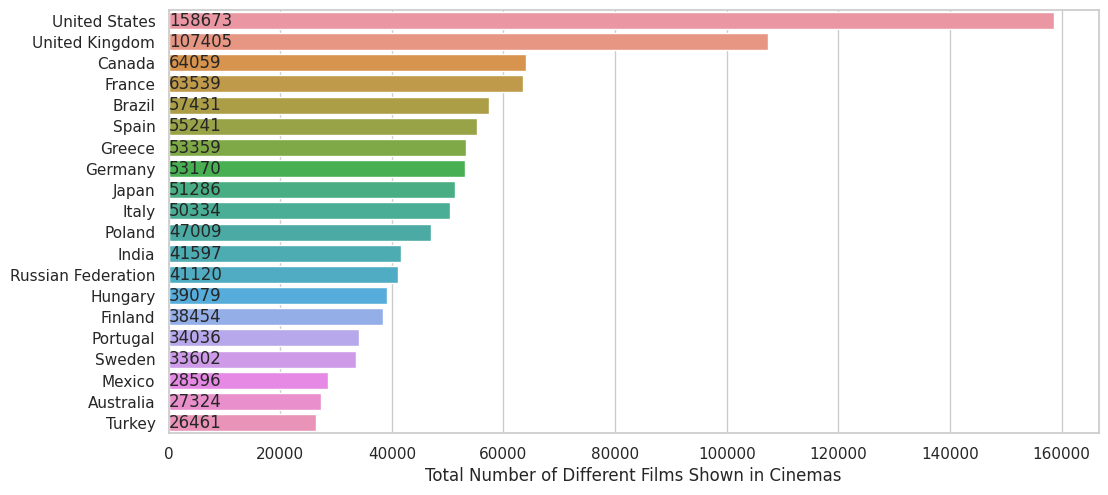

In [ ]:
# plot it to see US shows the most films 

sns.set(style='whitegrid')
plt.figure(figsize=(12,5.5))
sns.barplot(x=counts,y=country_names,orient="h")
plt.xlabel("Total Number of Different Films Shown in Cinemas")

for i, count in enumerate(counts):
    plt.text(100,i,count,va="center")

In [ ]:
country_counts = title_akas.region.value_counts()
country_counts_df = pd.DataFrame(country_counts).reset_index(level=0)
country_counts_df.columns = ['region', 'count']
country_counts_df = country_counts_df[(country_counts_df['region'] != 'XWG') & (country_counts_df['region'] != 'XWW')][:20]
country_list = country_counts_df.region.to_list()

In [ ]:
country_mean = title_akas.groupby('region')['averageRating'].agg(func='mean')
country_mean = country_mean.loc[country_mean.index.intersection(country_list)]

In [ ]:
country_mean

region
AU    6.041484
BR    6.103300
CA    6.111146
DE    5.995704
ES    6.032507
FI    6.260303
FR    6.098527
GB    5.962131
GR    6.132051
HU    6.261222
IN    6.237298
IT    6.078825
JP    6.247875
MX    6.157798
PL    6.238590
PT    6.196839
RU    6.023203
SE    6.209416
TR    6.043562
US    5.985543
Name: averageRating, dtype: float64

In [ ]:
title_akas2 = title_akas[title_akas['region'].isin(country_list)]
title_akas2.region.unique()

array(['DE', 'HU', 'US', 'AU', 'GB', 'FR', 'ES', 'SE', 'FI', 'PT', 'RU',
       'PL', 'IT', 'BR', 'JP', 'GR', 'TR', 'CA', 'MX', 'IN'], dtype=object)

<AxesSubplot:xlabel='region', ylabel='averageRating'>

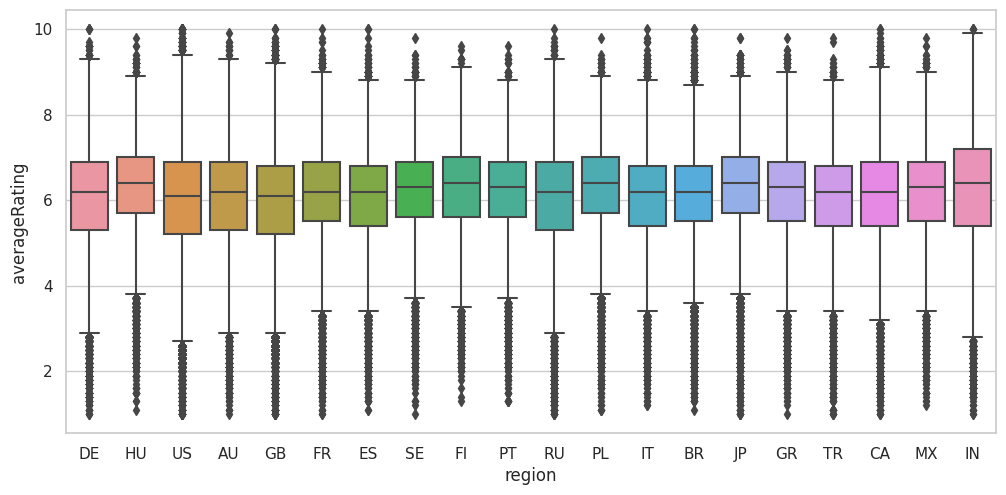

In [ ]:
# the top countries have similar ratings overall

sns.set(style='whitegrid')

plt.figure(figsize=(12,5.5))
sns.boxplot(x='region',
                y="averageRating",
                data=title_akas2)

In [ ]:
len(title_akas), len(movies)

(1781513, 218337)

In [ ]:
# checking for duplicates since movie id can appear in many countries

duplicate = title_akas[title_akas.duplicated(subset=['tconst', 'region'])]
duplicate.head()

tconst  ordering                   title region language        types  \
6   tt0000574         2  Ned Kelly and His Gang     AU      NaN  imdbDisplay   
12  tt0000574         8  Ned Kelly and His Gang    NaN      NaN          NaN   
25  tt0001285         4   The Victory of Israel     US      NaN          NaN   
27  tt0001285         6       The Life of Moses     US      NaN  imdbDisplay   
28  tt0001285         7    The Plagues of Egypt     US      NaN          NaN   

             attributes  isOriginalTitle  runtimeMinutes  \
6                   NaN              0.0              70   
12                  NaN              0.0              70   
25  fourth season title              0.0              50   
27                  NaN              0.0              50   
28     third part title              0.0              50   

              masterGenres  averageRating  
6                Adventure            6.0  
12               Adventure            6.0  
25  Documentary/Historical            5.6  
27  Documentary/Historical            5.6  
28  Documentary/Historical            5.6

<AxesSubplot:xlabel='region', ylabel='averageRating'>

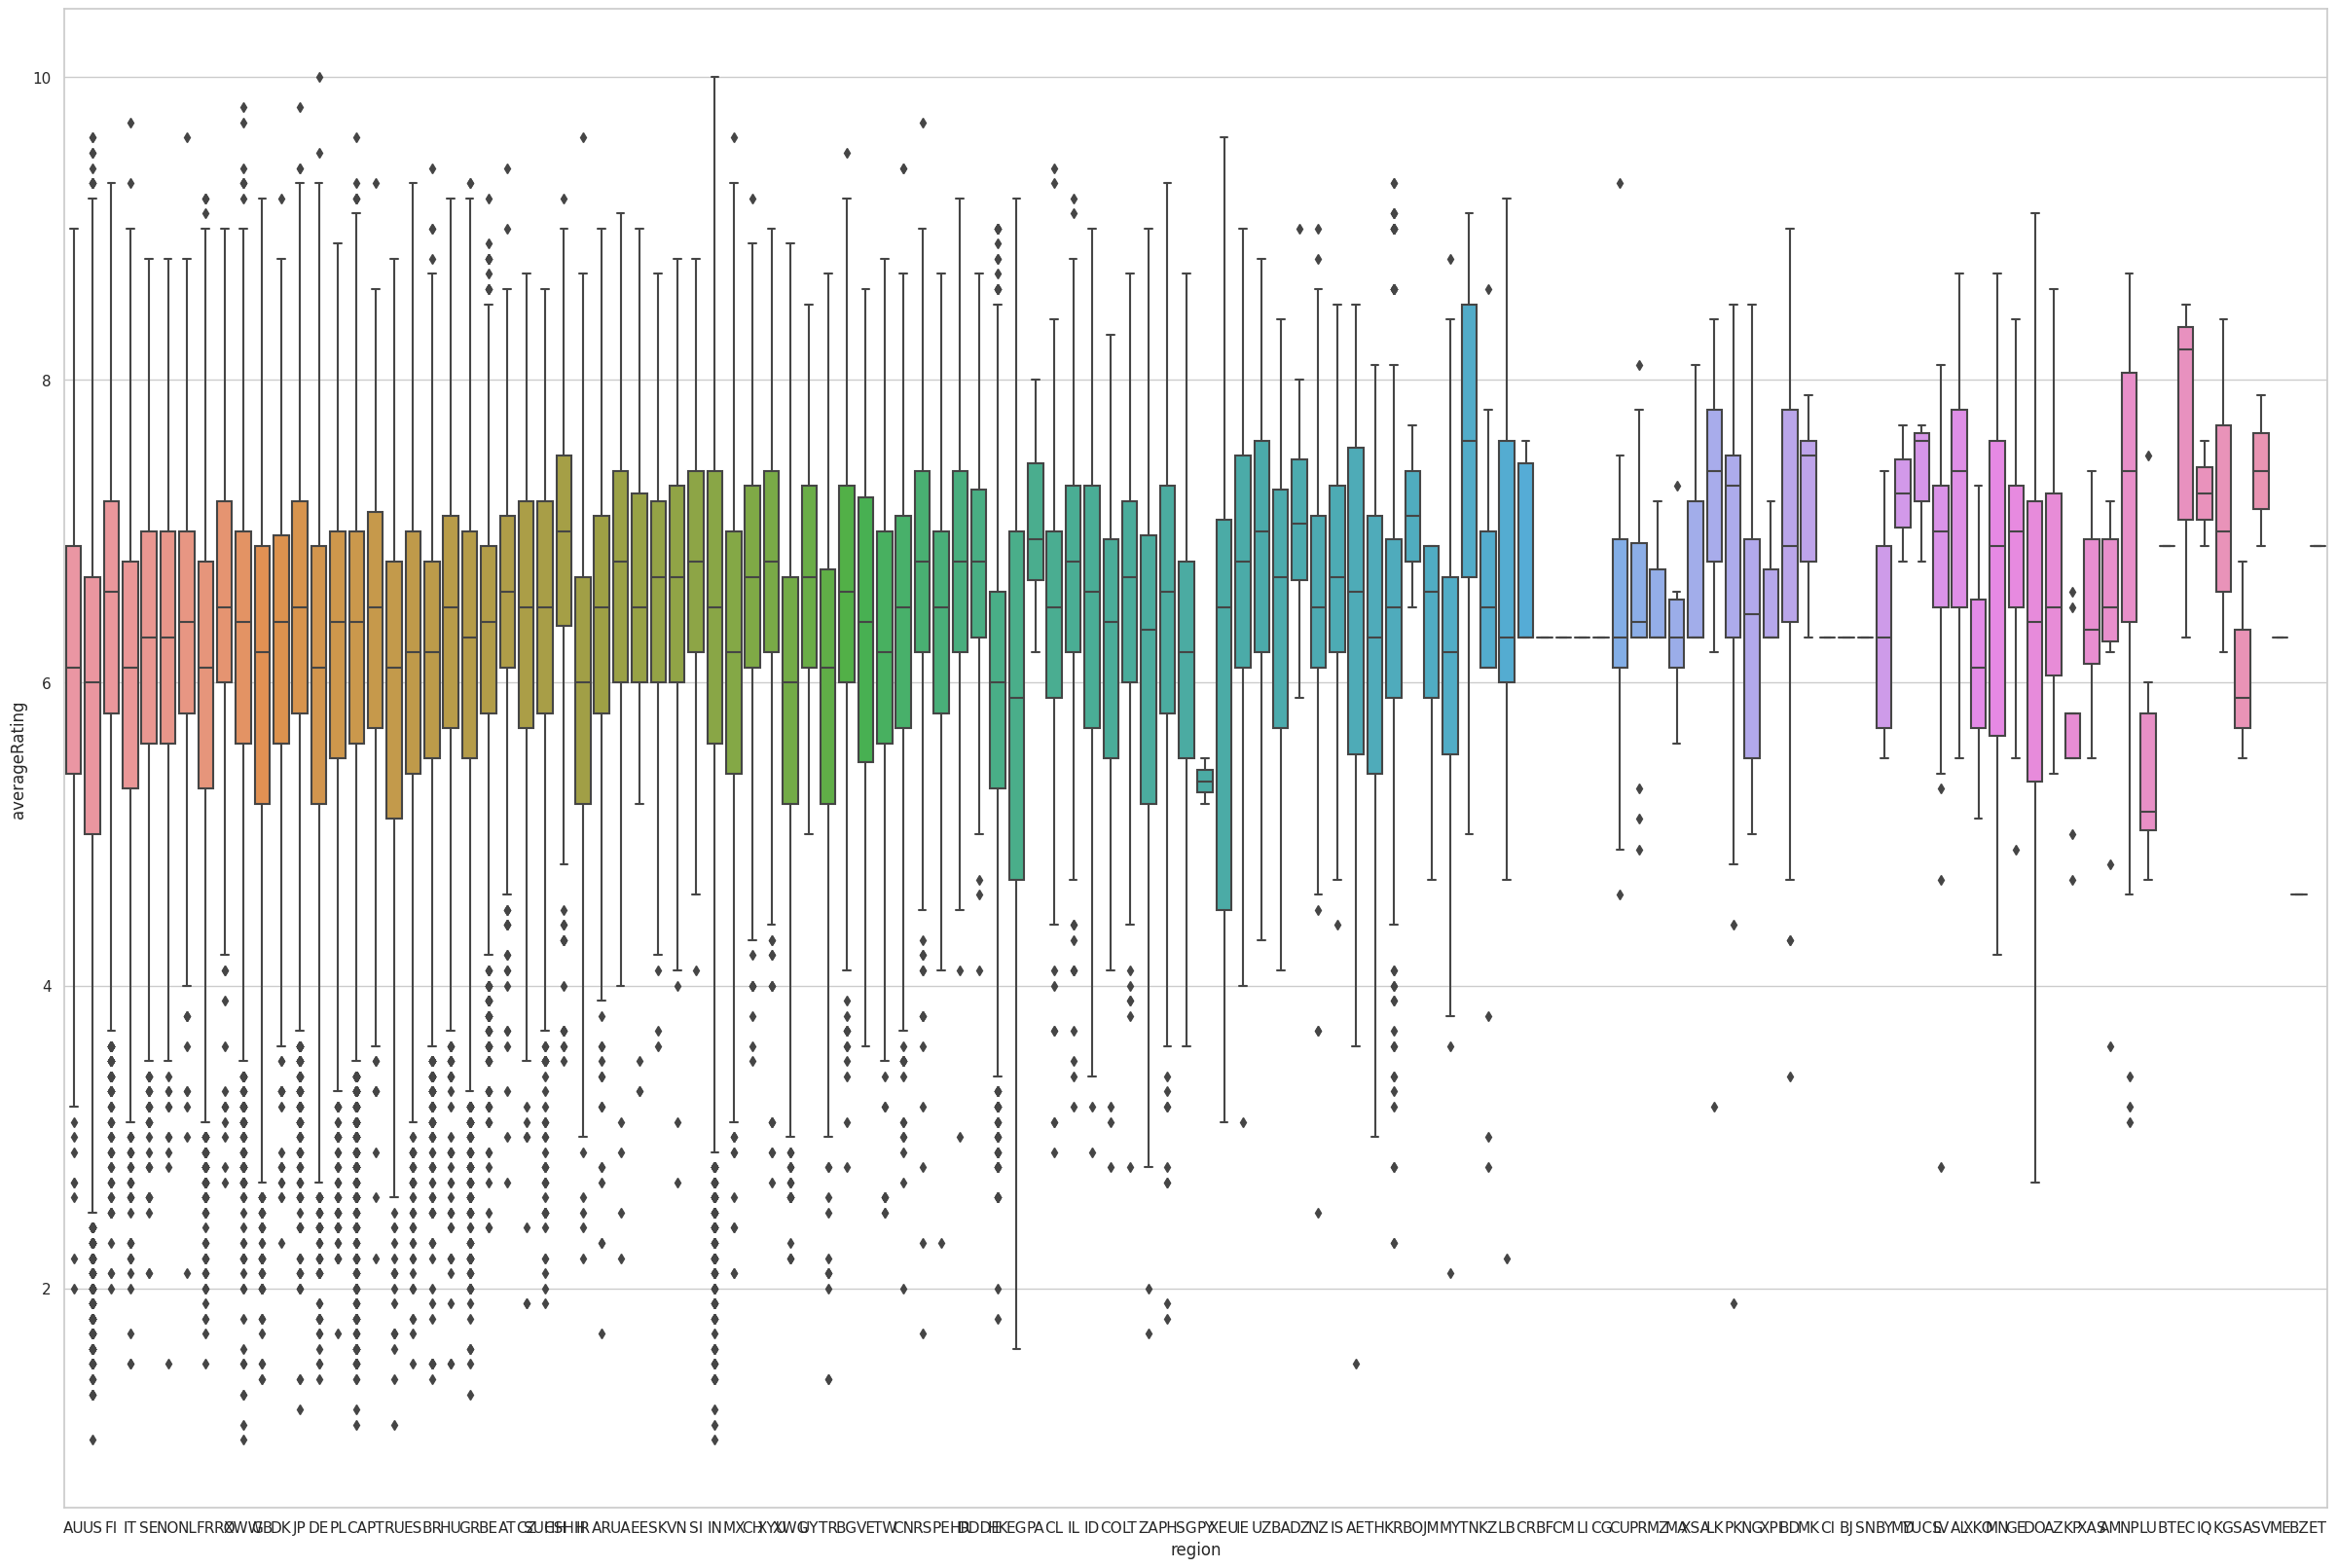

In [ ]:
# average rating by country overall does have more variance so I will want to encode this as a feature

sns.set(style='whitegrid')

plt.figure(figsize=(30,20))
sns.boxplot(x='region',
                y="averageRating",
                data=duplicate)

<AxesSubplot:xlabel='masterGenres', ylabel='averageRating'>

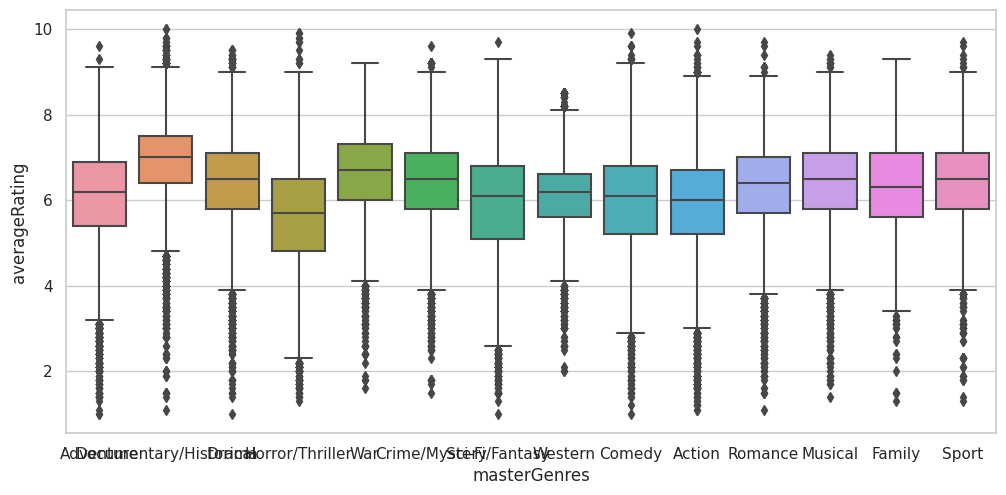

In [ ]:
# visualizing average rating by genre feature we created

sns.set(style='whitegrid')

plt.figure(figsize=(12,5.5))
sns.boxplot(x='masterGenres',
                y="averageRating",
                data=duplicate)

In [ ]:
title_akas_ratings = title_akas[['region', 'averageRating']]
title_akas_ratings.groupby('region').describe().unstack(1)

                      region
averageRating  count  AD           2.0
                      AE        6255.0
                      AF          38.0
                      AG           4.0
                      AL         534.0
                                 ...  
               max    YUCS         8.6
                      ZA           9.4
                      ZM           5.5
                      ZRCD         6.5
                      ZW           9.6
Length: 1744, dtype: float64

In [ ]:
# drop where region is null since we are going to encode features for where the film was released
title_akas = title_akas.dropna(subset='region')
len(title_akas)

1548759

### 2.6 Grouping countries into master regional feature

In [ ]:
# creating country groupings. Need to research subregions of Africa to incorporate more complete mapping
# the country codes here vary by year because of changes (e.g. Kosovo wasn't technically a country in 1990)

northAmerica = ['US','CA']
africa = ['MA','LY','DZ','EG','SD','TN','CM','ET','MU','RE','ML','GW','GN','TD','SL','SN','ZW','KE','BF','TZ','ER','CD','ST','ZA','CI','AO','LS','CG','GH','GA','RW','DJ','BJ','NE','CV','NG','MR','MW','LR','SO','UG','MG']
latAm = ['DO','HT','GY','PA','CU','GT','JM','EC','AW','LC','BZ','BO','SV','GD','VE','UY','TT','SR','GP','MX','CL','PR','NI','VI','PE','BS','MQ','BR','CO','HN','PY','AG','KN','AR','CR','BB','VC', 'BM']
centralAsia = ['KG','TJ','UZ','KZ','TM']
easternAsia = ['JP','TW','MN','HK','MO','KR','CN','KP']
southEastAsia = ['TL','TH','MY','KH','LA','SG','VN','PH','MM','ID','ID','BN', 'BUMM']
southernAsia = ['PK','LK','IR','IN','BT','BD','AF','MV','NP','VDVN', 'YUCS']
westernAsia = ['AE','AM','YE','TR','KW','BH','OM','IL','JO','LB','SY','PS','QA','GE','AZ','IQ','CY','SA']
easternEurope = ['CZ','HU','RO','RU','SK','PL','MD','UA','BY','BG', 'SUHH', 'XKO', 'CSHH', 'XKV', 'CSXX']
northernEurope = ['DK','LT','IE','IM','IS','FO','GB','NO','LV','SE','EE','FI','GL', 'XYU']
southernEurope = ['GI','PT','GR','HR','ME','MK','RS','IT','SM','AL','AD','VA','ES','SI','MT','BA','BA']
westernEurope = ['DE','CH','LI','LU','FR','NL','BE','MC','AT', 'DDDE', 'XEU', 'AN', 'XWG']
oceania = ['AU','NZ','PG','SB','FJ','NC','MH','GU','PF','AS','WS','TO']
worldwide = ['XWW']

In [ ]:
len(title_akas)

1548759

In [ ]:
# grouping countries using glorified case statement via np.where just like with genre

title_akas['releasedRegion'] = np.where(title_akas['region'].str.contains('|'.join(northAmerica)), 'northAmerica',
                                        np.where(title_akas['region'].str.contains('|'.join(africa)), 'africa',
                                        np.where(title_akas['region'].str.contains('|'.join(latAm)), 'latAm',
                                        np.where(title_akas['region'].str.contains('|'.join(centralAsia)), 'centralAsia',
                                        np.where(title_akas['region'].str.contains('|'.join(easternAsia)), 'easternAsia',
                                        np.where(title_akas['region'].str.contains('|'.join(southEastAsia)), 'southEastAsia',
                                        np.where(title_akas['region'].str.contains('|'.join(southernAsia)), 'southernAsia',
                                        np.where(title_akas['region'].str.contains('|'.join(westernAsia)), 'westernAsia',
                                        np.where(title_akas['region'].str.contains('|'.join(southernAsia)), 'southernAsia',
                                        np.where(title_akas['region'].str.contains('|'.join(easternEurope)), 'easternEurope',
                                        np.where(title_akas['region'].str.contains('|'.join(northernEurope)), 'northernEurope',
                                        np.where(title_akas['region'].str.contains('|'.join(southernEurope)), 'southernEurope',
                                        np.where(title_akas['region'].str.contains('|'.join(westernEurope)), 'westernEurope',
                                        np.where(title_akas['region'].str.contains('|'.join(oceania)), 'oceania',
                                        np.where(title_akas['region'].str.contains('|'.join(worldwide)), 'worldwide', 'other')))))))))))))))                                             

In [ ]:
title_akas = title_akas[['tconst', 'releasedRegion', 'region']]

In [ ]:
title_akas = title_akas.loc[title_akas['releasedRegion'] != 'other']

In [ ]:
# now I have the data in long format but need to transform it into wide so it can actually be used by ML models

title_akas = title_akas.drop_duplicates(subset=['tconst', 'releasedRegion'], keep='last').reset_index(drop=True)

In [ ]:
title_akas

tconst  releasedRegion region
0       tt0000009   westernEurope     DE
1       tt0000009   easternEurope     HU
2       tt0000009    northAmerica     US
3       tt0000574   easternEurope     HU
4       tt0000574         oceania     AU
...           ...             ...    ...
812908  tt9916362           latAm     AR
812909  tt9916362       worldwide    XWW
812910  tt9916362  southernEurope     PT
812911  tt9916362   easternEurope     RO
812912  tt9916538   southEastAsia     ID

[812913 rows x 3 columns]

In [ ]:
# hot encode new country feature using pivot

title_akas = title_akas.pivot(index='tconst', columns='releasedRegion', values='region').reset_index()

In [ ]:
title_akas.columns

Index(['tconst', 'africa', 'centralAsia', 'easternAsia', 'easternEurope',
       'latAm', 'northAmerica', 'northernEurope', 'oceania', 'southEastAsia',
       'southernAsia', 'southernEurope', 'westernAsia', 'westernEurope',
       'worldwide'],
      dtype='object', name='releasedRegion')

In [ ]:
# adding new feature to dataframe
movies = pd.merge(movies, title_akas[['tconst','africa', 'centralAsia', 'easternAsia', 'easternEurope',
                                      'latAm', 'northAmerica', 'northernEurope', 'oceania', 'southEastAsia',
                                      'southernAsia', 'southernEurope', 'westernAsia', 'westernEurope','worldwide']], on='tconst', how='left')

In [ ]:
del title_akas

In [ ]:
movies.to_csv('movies_df.csv')

Reset for RAM

In [ ]:
%reset

In [ ]:
import numpy as np
import pandas as pd
import requests
import re
import traceback
import unicodedata
import matplotlib.pyplot as plt
import pycountry
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime
from category_encoders.one_hot import OneHotEncoder
from sklearn.feature_selection import RFE
import warnings

# Hiding any warnings
warnings.filterwarnings('ignore')

In [ ]:
movies = pd.read_csv('movies_df.csv', index_col=0)

In [ ]:
movies = movies[movies['isAdult'] != 1]
movies = movies.drop('genres', axis=1)
movies = movies.drop('isAdult', axis=1)
movies = movies.drop('titleType', axis=1)
movies = movies.drop('originalTitle', axis=1)

### 2.7 Time series features

In [ ]:
percent_missing = movies.isnull().sum() * 100 / len(movies)
missing_value_movies = pd.DataFrame({'column_name': movies.columns, 'percent_missing': percent_missing})
missing_value_movies.sort_values(by='percent_missing', inplace=True, ascending=False)
missing_value_movies

column_name  percent_missing
centralAsia          centralAsia        99.377568
africa                    africa        96.008464
southEastAsia      southEastAsia        89.742462
oceania                  oceania        87.660360
westernAsia          westernAsia        85.732148
southernAsia        southernAsia        84.802393
worldwide              worldwide        75.997655
easternAsia          easternAsia        75.933076
latAm                      latAm        68.266487
southernEurope    southernEurope        62.077889
easternEurope      easternEurope        61.799878
westernEurope      westernEurope        58.347875
northernEurope    northernEurope        44.598946
producer                producer        39.888796
northAmerica        northAmerica        37.334488
composer                composer        35.770392
cinematographer  cinematographer        35.483679
actor3                    actor3        13.075200
actor2                    actor2        11.281185
actor1                    actor1         9.991893
actor                      actor         8.000018
tconst                    tconst         0.000000
primaryTitle        primaryTitle         0.000000
director                director         0.000000
masterGenres        masterGenres         0.000000
numVotes                numVotes         0.000000
averageRating      averageRating         0.000000
runtimeMinutes    runtimeMinutes         0.000000
startYear              startYear         0.000000
writer                    writer         0.000000

#### 2.71 Create original, re-release, and is re-released in future features

In [ ]:
# checking for duplicates based on tconst id
boolean = not movies["tconst"].is_unique      
boolean = movies['tconst'].duplicated().any() 
boolean

False

In [ ]:
# checking for duplicates based on movie name

boolean = not movies["primaryTitle"].is_unique      
boolean = movies['primaryTitle'].duplicated().any() 
boolean

True

In [ ]:
duplicate = movies[movies.duplicated(subset=['primaryTitle'])]
duplicate[['tconst','primaryTitle','startYear','numVotes','averageRating']].sort_values(by=['primaryTitle', 'numVotes'], ascending=False)[16:19:]

tconst primaryTitle  startYear  numVotes  averageRating
137666  tt13946146         Zoya       2021     975.0            3.5
177979   tt3565054         Zoya       2016      10.0            7.3
140730  tt14628216         Zoya       2018       8.0            3.5

In [ ]:
movies['dupe'] = movies.groupby(['primaryTitle']).cumcount()+1

In [ ]:
# creating fucntions to label whether the movie is an original release vs re-release

def label_original (row):
       if row['dupe'] == 1:
           return 1
       else:
           0
       
def label_reRelease (row):
       if row['dupe'] > 1:
           return 1
       else:
           0

In [ ]:
movies['isOriginal'] = movies.apply(lambda row: label_original(row), axis=1)
movies['isOriginal'] = movies['isOriginal'].replace(np.nan, 0)

movies['isReRelease'] = movies.apply(lambda row: label_reRelease(row), axis=1)
movies['isReRelease'] = movies['isReRelease'].replace(np.nan, 0)

In [ ]:
# creating feature for whether the film is rereleased in the future as this may indicate success / rating

vals_to_replace = {0:1, 1:0}
movies['isReReleasedInFuture'] = movies.index.isin(movies.groupby('primaryTitle')['dupe'].idxmax()).astype(int)
movies['isReReleasedInFuture'] = movies['isReReleasedInFuture'].map(vals_to_replace)

In [ ]:
# sanity check

movies[movies['primaryTitle'] == 'Zoya']

tconst primaryTitle  startYear  runtimeMinutes  averageRating  \
13530    tt0037482         Zoya       1944              95            6.9   
137666  tt13946146         Zoya       2021             105            3.5   
140730  tt14628216         Zoya       2018              74            3.5   
177979   tt3565054         Zoya       2016              82            7.3   

        numVotes masterGenres                actor                actor1  \
13530       85.0          War     Kseniya Tarasova  Galina Vodyanitskaya   
137666     975.0          War  Mindaugas Papinigis        Wolfgang Cerny   
140730       8.0          War    Aleksandr Demidov       Vladimir Dyomin   
177979      10.0          War            Christina       Hossein Mardani   

                       actor2  ... southEastAsia southernAsia southernEurope  \
13530   Yekaterina Skvortsova  ...           NaN          NaN             IT   
137666     Jean-Marc Birkholz  ...           NaN          NaN            NaN   
140730        Egor Katushenko  ...           NaN          NaN            NaN   
177979      Beka Sikharulidze  ...           NaN          NaN            NaN   

       westernAsia westernEurope worldwide dupe isOriginal isReRelease  \
13530          NaN            FR       NaN    1        1.0         0.0   
137666         NaN           NaN       NaN    2        0.0         1.0   
140730         NaN           NaN       NaN    3        0.0         1.0   
177979         NaN           NaN       NaN    4        0.0         1.0   

       isReReleasedInFuture  
13530                     1  
137666                    1  
140730                    1  
177979                    0  

[4 rows x 34 columns]

In [ ]:
# dropping dupe column that helped me create these features

movies = movies.drop('dupe', axis=1)

#### 2.72 Create movie age feature

In [ ]:
# get current year

current_year = datetime.now().year
current_year

2022

In [ ]:
# create movie age column based on number of years since original release
for index, row in movies.iterrows():
    movie_id = row['tconst']
    year_released = row['startYear']
    movie_age = current_year - year_released
    movies.loc[index, 'movieAge'] = movie_age

### 2.3 Hot encode genre feature

In [ ]:
movies.isna().sum()

tconst                       0
primaryTitle                 0
startYear                    0
runtimeMinutes               0
averageRating                0
numVotes                     0
masterGenres                 0
actor                    17467
actor1                   21816
actor2                   24631
actor3                   28548
cinematographer          77474
composer                 78100
director                     0
producer                 87092
writer                       0
africa                  209622
centralAsia             216978
easternAsia             165790
easternEurope           134932
latAm                   149051
northAmerica             81515
northernEurope           97376
oceania                 191395
southEastAsia           195941
southernAsia            185155
southernEurope          135539
westernAsia             187185
westernEurope           127395
worldwide               165931
isOriginal                   0
isReRelease                  0
isReRele

In [ ]:
# using onehotencoder to encode genre and then merge it back

genre_encoder = OneHotEncoder(use_cat_names= True, handle_unknown='ignore')
genre_dummy = genre_encoder.fit_transform(movies['masterGenres'])

In [ ]:
movies = pd.concat([movies, genre_dummy], axis=1)

In [ ]:
movies = movies.drop('masterGenres', axis=1)

In [ ]:
del boolean, current_year, duplicate, genre_dummy, genre_encoder, index, missing_value_movies, movie_age, movie_id, percent_missing, row, vals_to_replace, year_released

### 2.4 Filtering out films where region is completely unavailable

In [ ]:
movies['missingRegion'] = np.where(movies[['africa', 'centralAsia', 'easternAsia', 'easternEurope',
                                           'latAm', 'northAmerica', 'northernEurope', 'oceania', 'southEastAsia',
                                           'southernAsia', 'southernEurope', 'westernAsia', 'westernEurope','worldwide']].isnull().all(1),1,0)

In [ ]:
len(movies[movies['missingRegion'] == 1])

374

In [ ]:
movies = movies[movies['missingRegion'] != 1]

In [ ]:
len(movies[movies['missingRegion'] == 1])

0

In [ ]:
movies = movies.drop('missingRegion', axis=1)

In [ ]:
len(movies)

217963

In [ ]:
movies[['africa', 'centralAsia', 'easternAsia', 'easternEurope',
        'latAm', 'northAmerica', 'northernEurope', 'oceania', 'southEastAsia',
        'southernAsia', 'southernEurope', 'westernAsia', 'westernEurope','worldwide']] = movies[['africa', 'centralAsia', 'easternAsia', 'easternEurope',
                                                                                                 'latAm', 'northAmerica', 'northernEurope', 'oceania', 'southEastAsia',
                                                                                                 'southernAsia', 'southernEurope', 'westernAsia', 'westernEurope','worldwide']].fillna(value=0)

In [ ]:
cols = ['africa', 'centralAsia', 'easternAsia', 'easternEurope','latAm', 'northAmerica', 'northernEurope', 'oceania', 'southEastAsia','southernAsia', 'southernEurope', 'westernAsia', 'westernEurope','worldwide']
movies[cols] = movies[cols].replace(regex='([a-zA-Z])', value=1)

In [ ]:
f"min easternAsia is: {movies.easternAsia.min()}, max easternAsia is: {movies.easternAsia.max()}"

'min easternAsia is: 0, max easternAsia is: 1'

### 2.5 Filter outliers by movie age

In [ ]:
movies['movieAge'] = movies['movieAge'].astype(float)

In [ ]:
standard_deviations = 2.5
movies = movies[((movies['movieAge'] - movies['movieAge'].mean()) / movies['movieAge'].std()).abs() < standard_deviations]

In [ ]:
# filter out for only moves from 1990 onwards as that is when most of the votes happened
# my hypotnesis is that the lack of voting may indicate skewed results for rating because few votes had lots of power before the 90s based on my analysis

movies = movies[movies['startYear'] >= 1990]

### 2.6 Filter outliers by votes

In [ ]:
movies['numVotes'] = movies['numVotes'].astype(float)

In [ ]:
# same methodology using 2.5 standard deviations from the mean to filter outliers

standard_deviations = 2.5
movies = movies[((movies['numVotes'] - movies['numVotes'].mean()) / movies['numVotes'].std()).abs() < standard_deviations]

In [ ]:
len(movies)

137699

### 2.7 Hot encode cast features 
* director, writer, actors, composers, producers, etc...
* these encodings are essentially to to infer production budget

#### 2.71 Director features

In [ ]:
movies.groupby('director', as_index=False)['averageRating'].mean().sort_values(by='averageRating',ascending=False)

director  averageRating
64152      Syed Jobair Ahmed           10.0
42433  Marius Nordeng Mellem           10.0
40884            Mainak Paul           10.0
13349           Crystal Kwok           10.0
50623   P. Sunil Kumar Reddy           10.0
...                      ...            ...
71128            Zeki Akinci            1.0
24504             Gökhan Gök            1.0
70740              Yunsu Kim            1.0
25986          Hristos Godas            1.0
43653          Matey Genchev            1.0

[71572 rows x 2 columns]

In [ ]:
movies.groupby('director', as_index=False)['tconst'].nunique().sort_values(by='tconst',ascending=False)

director  tconst
31138          Jing Wong      80
31628      Joel Lamangan      69
25536         Herman Yau      65
64461      Takashi Miike      63
54440    Ram Gopal Varma      55
...                  ...     ...
28949      Jarvis Alston       1
28950     Jarvis Greiner       1
28953     Jasco Viefhues       1
28954       Jashan Makan       1
71571  Þorsteinn Jónsson       1

[71572 rows x 2 columns]

In [ ]:
# taking top 50 directors since they had the most unique number per film and a director may be a good approximation for budget
# my assumption is budget is probably a good indicator for movie rating since if you have more funds you can get a quality director

top_directors = movies.director.value_counts().head(50)

In [ ]:
top_directors

Jing Wong              80
Joel Lamangan          69
Herman Yau             65
Takashi Miike          63
Ram Gopal Varma        55
Sergey A.              54
David DeCoteau         50
Nayato Fio Nuala       50
Priyadarshan           48
Jose Javier Reyes      48
Johnnie To             47
Fred Olen Ray          45
Michael Fredianelli    45
David Dhawan           41
Carlo Vanzina          40
Andrew Lau             39
Sion Sono              35
Dustin Ferguson        35
Ryûichi Hiroki         35
Puri Jagannadh         34
Claudio Costa          33
Hanung Bramantyo       32
Rizal Mantovani        32
Yukihiko Tsutsumi      32
Yen-Ping Chu           32
Jim Wynorski           32
Jean-Pierre Mocky      31
Charles Band           31
Darrell Roodt          30
Uwe Boll               30
Neri Parenti           29
Wenn V. Deramas        29
Takahisa Zeze          29
Hark Tsui              29
Joe Ma                 29
Chito S. Roño          29
Vikram Bhatt           29
Hong Sang-soo          28
Kamal       

In [ ]:
top_directors = [x for x in movies.director.value_counts().sort_values(ascending=False).head(50).index]

In [ ]:
top_directors

['Jing Wong',
 'Joel Lamangan',
 'Herman Yau',
 'Takashi Miike',
 'Ram Gopal Varma',
 'Sergey A.',
 'David DeCoteau',
 'Nayato Fio Nuala',
 'Jose Javier Reyes',
 'Priyadarshan']

In [ ]:
# create label for encoding top directors

for label in top_directors:
    movies[label] = np.where(movies['director']==label,1,0)

movies[['director']+top_directors]

director  Jing Wong  Joel Lamangan  Herman Yau  \
1713    Eva López Sánchez          0              0           0   
12136       James Mangold          0              0           0   
28370     Jürgen Böttcher          0              0           0   
28755        Egon Günther          0              0           0   
30255           Raúl Ruiz          0              0           0   
...                   ...        ...            ...         ...   
218332    Tamar Guimaraes          0              0           0   
218333    Fraser Precious          0              0           0   
218334     Giacomo Cimini          0              0           0   
218335       Pablo Agüero          0              0           0   
218336  Azhar Kinoi Lubis          0              0           0   

        Takashi Miike  Ram Gopal Varma  Sergey A.  David DeCoteau  \
1713                0                0          0               0   
12136               0                0          0               0   
28370               0                0          0               0   
28755               0                0          0               0   
30255               0                0          0               0   
...               ...              ...        ...             ...   
218332              0                0          0               0   
218333              0                0          0               0   
218334              0                0          0               0   
218335              0                0          0               0   
218336              0                0          0               0   

        Nayato Fio Nuala  Jose Javier Reyes  Priyadarshan  
1713                   0                  0             0  
12136                  0                  0             0  
28370                  0                  0             0  
28755                  0                  0             0  
30255                  0                  0             0  
...                  ...                ...           ...  
218332                 0                  0             0  
218333                 0                  0             0  
218334                 0                  0             0  
218335                 0                  0             0  
218336                 0                  0             0  

[137699 rows x 11 columns]

#### 2.72 Actor features

In [ ]:
movies.groupby('actor', as_index=False)['averageRating'].mean().sort_values(by='averageRating',ascending=False)

actor  averageRating
18106            Frank McKinney IV           10.0
6285   Batyrkhan Abayevich Malikov           10.0
24819                Jeffery Black           10.0
14782                   Dorren Lee           10.0
43800                Petru Hadarca           10.0
...                            ...            ...
890                    Ahmet Çevik            1.0
6525                 Benekli Ayhan            1.0
1097                         Akino            1.0
58182                  Yumiko Hara            1.0
14488               Doga Konakoglu            1.0

[58937 rows x 2 columns]

In [ ]:
movies.groupby('actor', as_index=False)['tconst'].nunique().sort_values(by='tconst',ascending=False)

actor  tconst
16543     Eric Roberts     159
39324         Mohanlal      97
48754      Sanjay Dutt      90
44312      Prakash Raj      86
34461        Mammootty      83
...                ...     ...
23078  Jack Noseworthy       1
23082        Jack Parr       1
23084     Jack Queralt       1
23085     Jack Reiling       1
29468   Katie McGovern       1

[58937 rows x 2 columns]

In [ ]:
# I would do more actors in the future but do not have time to handle the compute

top_actors = [x for x in movies.actor.value_counts().sort_values(ascending=False).head(50).index]

In [ ]:
top_actors

['Eric Roberts',
 'Mohanlal',
 'Sanjay Dutt',
 'Prakash Raj',
 'Mammootty',
 'Simon Yam',
 'Gérard Depardieu',
 'Amitabh Bachchan',
 'Anthony Chau-Sang Wong',
 'Lance Henriksen']

In [ ]:
# hot encode top

for label in top_actors:
    movies[label] = np.where(movies['actor']==label,1,0)

movies[['actor']+top_actors]

actor  Eric Roberts  Mohanlal  Sanjay Dutt  \
1713    Rafael Sánchez Navarro             0         0            0   
12136                 Meg Ryan             0         0            0   
28370        Monika Hildebrand             0         0            0   
28755             Manfred Krug             0         0            0   
30255          Rubén Sotoconil             0         0            0   
...                        ...           ...       ...          ...   
218332            Germano Melo             0         0            0   
218333             Akie Kotabe             0         0            0   
218334      Sergio Castellitto             0         0            0   
218335         Alex Brendemühl             0         0            0   
218336              Ria Irawan             0         0            0   

        Prakash Raj  Mammootty  Simon Yam  Gérard Depardieu  Amitabh Bachchan  \
1713              0          0          0                 0                 0   
12136             0          0          0                 0                 0   
28370             0          0          0                 0                 0   
28755             0          0          0                 0                 0   
30255             0          0          0                 0                 0   
...             ...        ...        ...               ...               ...   
218332            0          0          0                 0                 0   
218333            0          0          0                 0                 0   
218334            0          0          0                 0                 0   
218335            0          0          0                 0                 0   
218336            0          0          0                 0                 0   

        Anthony Chau-Sang Wong  Lance Henriksen  
1713                         0                0  
12136                        0                0  
28370                        0                0  
28755                        0                0  
30255                        0                0  
...                        ...              ...  
218332                       0                0  
218333                       0                0  
218334                       0                0  
218335                       0                0  
218336                       0                0  

[137699 rows x 11 columns]

In [ ]:
movies = movies.drop(['actor','actor1', 'actor2', 'actor3', 'director'], axis=1)

In [ ]:
movies.groupby('producer', as_index=False)['tconst'].nunique().sort_values(by='tconst',ascending=False)

producer  tconst
44075  Vincent Del Rosario III     207
33308             Paulo Branco     185
9937        David Michael Latt     112
6936       Chand Parwez Servia      91
10954        Domenico Procacci      89
...                        ...     ...
18086             Jamie Palmer       1
18089           Jamie Popowich       1
18091             Jamie Schutz       1
18092            Jamie Selkirk       1
45951     Þórunn Guðjónsdóttir       1

[45952 rows x 2 columns]

#### 2.73 Producer feature

In [ ]:
# same feature creation methodology for producers

top_producers = [x for x in movies.producer.value_counts().sort_values(ascending=False).head(50).index]

In [ ]:
top_producers

['Vincent Del Rosario III',
 'Paulo Branco',
 'David Michael Latt',
 'Chand Parwez Servia',
 'Domenico Procacci',
 'Sergey Selyanov',
 'Shrikant Mohta',
 'Alain Sarde',
 'Olivier Delbosc',
 'Gerardo Herrero']

In [ ]:
for label in top_producers:
    movies[label] = np.where(movies['producer']==label,1,0)

movies[['producer']+top_producers]

producer  Vincent Del Rosario III  Paulo Branco  \
1713    Gustavo Montiel Pagés                        0             0   
12136            Cathy Konrad                        0             0   
28370                     NaN                        0             0   
28755                     NaN                        0             0   
30255       Chamila Rodríguez                        0             0   
...                       ...                      ...           ...   
218332                    NaN                        0             0   
218333                    NaN                        0             0   
218334          Arturo Paglia                        0             0   
218335            Iker Ganuza                        0             0   
218336          M. Abduh Aziz                        0             0   

        David Michael Latt  Chand Parwez Servia  Domenico Procacci  \
1713                     0                    0                  0   
12136                    0                    0                  0   
28370                    0                    0                  0   
28755                    0                    0                  0   
30255                    0                    0                  0   
...                    ...                  ...                ...   
218332                   0                    0                  0   
218333                   0                    0                  0   
218334                   0                    0                  0   
218335                   0                    0                  0   
218336                   0                    0                  0   

        Sergey Selyanov  Shrikant Mohta  Alain Sarde  Olivier Delbosc  \
1713                  0               0            0                0   
12136                 0               0            0                0   
28370                 0               0            0                0   
28755                 0               0            0                0   
30255                 0               0            0                0   
...                 ...             ...          ...              ...   
218332                0               0            0                0   
218333                0               0            0                0   
218334                0               0            0                0   
218335                0               0            0                0   
218336                0               0            0                0   

        Gerardo Herrero  
1713                  0  
12136                 0  
28370                 0  
28755                 0  
30255                 0  
...                 ...  
218332                0  
218333                0  
218334                0  
218335                0  
218336                0  

[137699 rows x 11 columns]

#### 2.74 Writer feature

In [ ]:
# same feature methodology for writers

movies.groupby('writer', as_index=False)['tconst'].nunique().sort_values(by='tconst',ascending=False)

writer  tconst
81397      William Shakespeare     215
36648                Jing Wong     120
27524  Gopalakrishna Paruchuri      78
65065              Ricardo Lee      66
7766               BC Fourteen      62
...                        ...     ...
32294              Ja-hong Koo       1
32296              Jaahan Kaur       1
32297          Jaajo Linnonmaa       1
32299         Jaakko Heinimäki       1
83739       Þórunn Lárusdóttir       1

[83740 rows x 2 columns]

In [ ]:
top_writers = [x for x in movies.writer.value_counts().sort_values(ascending=False).head(50).index]

In [ ]:
top_writers

['William Shakespeare',
 'Jing Wong',
 'Gopalakrishna Paruchuri',
 'Ricardo Lee',
 'BC Fourteen',
 'Sergey A.',
 'Mel Mendoza-Del Rosario',
 'Kona Venkat',
 'Enrico Vanzina',
 'Jose Javier Reyes']

In [ ]:
for label in top_writers:
    movies[label] = np.where(movies['writer']==label,1,0)

movies[['writer']+top_writers]

writer  William Shakespeare  Jing Wong  \
1713    David Martin del Campo                    0          0   
12136            Steven Rogers                    0          0   
28370              Klaus Poche                    0          0   
28755             Helga Schütz                    0          0   
30255     Omar Saavedra Santis                    0          0   
...                        ...                  ...        ...   
218332         Melissa de Raaf                    0          0   
218333         Fraser Precious                    0          0   
218334        Lorenzo Collalti                    0          0   
218335          Katell Guillou                    0          0   
218336           Salman Aristo                    0          0   

        Gopalakrishna Paruchuri  Ricardo Lee  BC Fourteen  Sergey A.  \
1713                          0            0            0          0   
12136                         0            0            0          0   
28370                         0            0            0          0   
28755                         0            0            0          0   
30255                         0            0            0          0   
...                         ...          ...          ...        ...   
218332                        0            0            0          0   
218333                        0            0            0          0   
218334                        0            0            0          0   
218335                        0            0            0          0   
218336                        0            0            0          0   

        Mel Mendoza-Del Rosario  Kona Venkat  Enrico Vanzina  \
1713                          0            0               0   
12136                         0            0               0   
28370                         0            0               0   
28755                         0            0               0   
30255                         0            0               0   
...                         ...          ...             ...   
218332                        0            0               0   
218333                        0            0               0   
218334                        0            0               0   
218335                        0            0               0   
218336                        0            0               0   

        Jose Javier Reyes  
1713                    0  
12136                   0  
28370                   0  
28755                   0  
30255                   0  
...                   ...  
218332                  0  
218333                  0  
218334                  0  
218335                  0  
218336                  0  

[137699 rows x 11 columns]

#### 2.75 Cinematographer feature

In [ ]:
# same feature methodology for cinematographers

movies.groupby('cinematographer', as_index=False)['tconst'].nunique().sort_values(by='tconst',ascending=False)

cinematographer  tconst
11902       Hélène Louvart      63
18211       Mahmoud Kalari      63
11742        Howard Wexler      62
17012  Kwong-Hung Joe Chan      55
685          Albert Banzon      55
...                    ...     ...
13265    Jason Satterfield       1
13264        Jason Salonen       1
13263           Jason Ryan       1
13262       Jason Rutledge       1
32138          Ümit Özyurt       1

[32139 rows x 2 columns]

In [ ]:
top_cinematographers = [x for x in movies.cinematographer.value_counts().sort_values(ascending=False).head(50).index]

In [ ]:
top_cinematographers

['Hélène Louvart',
 'Mahmoud Kalari',
 'Howard Wexler',
 'Albert Banzon',
 'Kwong-Hung Joe Chan',
 'Anandakuttan',
 'Gary Graver',
 'Chiu-Lam Ko',
 'Maurizio Calvesi',
 'José Luis Alcaine']

In [ ]:
for label in top_cinematographers:
    movies[label] = np.where(movies['cinematographer']==label,1,0)

movies[['cinematographer']+top_cinematographers]

cinematographer  Hélène Louvart  Mahmoud Kalari  Howard Wexler  \
1713      Rodrigo Prieto               0               0              0   
12136    Stuart Dryburgh               0               0              0   
28370        Roland Gräf               0               0              0   
28755     Helmut Grewald               0               0              0   
30255     Diego Bonacina               0               0              0   
...                  ...             ...             ...            ...   
218332   Barbara Alvarez               0               0              0   
218333        Tom Walder               0               0              0   
218334  Maurizio Calvesi               0               0              0   
218335               NaN               0               0              0   
218336               NaN               0               0              0   

        Albert Banzon  Kwong-Hung Joe Chan  Anandakuttan  Gary Graver  \
1713                0                    0             0            0   
12136               0                    0             0            0   
28370               0                    0             0            0   
28755               0                    0             0            0   
30255               0                    0             0            0   
...               ...                  ...           ...          ...   
218332              0                    0             0            0   
218333              0                    0             0            0   
218334              0                    0             0            0   
218335              0                    0             0            0   
218336              0                    0             0            0   

        Chiu-Lam Ko  Maurizio Calvesi  José Luis Alcaine  
1713              0                 0                  0  
12136             0                 0                  0  
28370             0                 0                  0  
28755             0                 0                  0  
30255             0                 0                  0  
...             ...               ...                ...  
218332            0                 0                  0  
218333            0                 0                  0  
218334            0                 1                  0  
218335            0                 0                  0  
218336            0                 0                  0  

[137699 rows x 11 columns]

#### 2.76 Composer feature

In [ ]:
# same feature methodology for writers but only including 5 for compute

top_composers = [x for x in movies.composer.value_counts().sort_values(ascending=False).head(50).index]
top_composers

['Kevin MacLeod', 'Ilaiyaraaja', 'Anu Malik', 'Gopi Sundar', 'Mani Sharma']

In [ ]:
for label in top_composers:
    movies[label] = np.where(movies['composer']==label,1,0)

movies[['composer']+top_cinematographers]

composer  Hélène Louvart  Mahmoud Kalari  Howard Wexler  \
1713             José Elorza               0               0              0   
12136             Rolfe Kent               0               0              0   
28370          Wolf Biermann               0               0              0   
28755           Wilhelm Neef               0               0              0   
30255        Jorge Arriagada               0               0              0   
...                      ...             ...             ...            ...   
218332                   NaN               0               0              0   
218333     Simone Vallecorsa               0               0              0   
218334      Dimitri Scarlato               0               0              0   
218335  Maite Arroitajauregi               0               0              0   
218336          Dave Lumenta               0               0              0   

        Albert Banzon  Kwong-Hung Joe Chan  Anandakuttan  Gary Graver  \
1713                0                    0             0            0   
12136               0                    0             0            0   
28370               0                    0             0            0   
28755               0                    0             0            0   
30255               0                    0             0            0   
...               ...                  ...           ...          ...   
218332              0                    0             0            0   
218333              0                    0             0            0   
218334              0                    0             0            0   
218335              0                    0             0            0   
218336              0                    0             0            0   

        Chiu-Lam Ko  Maurizio Calvesi  José Luis Alcaine  
1713              0                 0                  0  
12136             0                 0                  0  
28370             0                 0                  0  
28755             0                 0                  0  
30255             0                 0                  0  
...             ...               ...                ...  
218332            0                 0                  0  
218333            0                 0                  0  
218334            0                 1                  0  
218335            0                 0                  0  
218336            0                 0                  0  

[137699 rows x 11 columns]

In [ ]:
movies = movies.drop(['producer','writer'], axis=1)

In [ ]:
movies = movies.drop(['cinematographer','composer'], axis=1)

In [ ]:
movies.isna().sum()[:20]

tconst            0
primaryTitle      0
startYear         0
runtimeMinutes    0
averageRating     0
numVotes          0
africa            0
centralAsia       0
easternAsia       0
easternEurope     0
latAm             0
northAmerica      0
northernEurope    0
oceania           0
southEastAsia     0
southernAsia      0
southernEurope    0
westernAsia       0
westernEurope     0
worldwide         0
dtype: int64

# Part 3: Data cleaning

### 3.1 Scaling features
* numVotes, movieAge, and runtimeMinutes are all on difference scales so I am using minmax to put them each on a scale from 0,1 to compare apples to apples

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [ ]:
scaler = MinMaxScaler()
movies[['numVotes']] = scaler.fit_transform(movies[['numVotes']])


In [ ]:
movies[['runtimeMinutes']] = scaler.fit_transform(movies[['runtimeMinutes']])

In [ ]:
movies[['movieAge']] = scaler.fit_transform(movies[['movieAge']])

In [ ]:
movies[['runtimeMinutes', 'numVotes', 'movieAge']]

runtimeMinutes  numVotes  movieAge
1713          0.291667  0.000176   0.90625
12136         0.339286  0.706014   0.65625
28370         0.285714  0.002042   1.00000
28755         0.220238  0.000259   1.00000
30255         0.196429  0.001305   0.06250
...                ...       ...       ...
218332        0.139881  0.000008   0.09375
218333        0.270833  0.001924   0.06250
218334        0.238095  0.011237   0.06250
218335        0.261905  0.040120   0.06250
218336        0.354167  0.000008   0.09375

[137699 rows x 3 columns]

#### 3.12 Cast isOriginal & isReRelease features as integers

In [ ]:
movies.isOriginal.unique()

array([1., 0.])

In [ ]:
movies.isOriginal = movies.isOriginal.astype('int')

In [ ]:
movies.isReRelease = movies.isReRelease.astype('int')

#### 3.13 Remove startYear
* we have replaced this feature with movieAge

In [ ]:
movies = movies.drop('startYear', axis=1)

### 3.2 Feature Review
* looking to see how each feature correlates to average rating

In [ ]:
correlation = movies[movies.columns[2:]].corr()['averageRating'][:]

In [ ]:
correlation= correlation.sort_values(ascending=False)
correlation

averageRating                          1.000000
masterGenres_Documentary/Historical    0.329790
masterGenres_Drama                     0.089684
masterGenres_Musical                   0.059603
worldwide                              0.047408
                                         ...   
masterGenres_Sci-Fi/Fantasy           -0.080515
easternEurope                         -0.081321
masterGenres_Action                   -0.121709
northernEurope                        -0.131337
masterGenres_Horror/Thriller          -0.255516
Name: averageRating, Length: 87, dtype: float64

In [ ]:
fig = plt.figure(figsize=(36,36), dpi = 480)
sns.heatmap(correlation.to_frame(),annot=True, annot_kws={'size':12},cmap="GnBu", fmt ='.2f')

<AxesSubplot:>

### 3.3 PCA
* Most of my independent variables are categorical hot encodings for the cast as an approximation of budget
but are not very correlated with rating. Going to reduce the dimensions using PCA for compute
* Con for PCA is that we lose interpretability of the models

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px

In [ ]:
scaler = StandardScaler()

In [ ]:
movies_temp = movies.drop(columns = ['tconst', 'primaryTitle'])


In [ ]:
len(movies_temp), len(movies)

(137699, 137699)

#### 3.31 Creating label classifications 
We will treat movie predictions as a classification problem and use classification models to predict ratings. The assumption is that groups of ratings are similar enough to each other to simplify compared to floats

I will group ratings into classes as follows:
* Rank1: rating between 0 and 2
* Rank2: rating between 2 and 4
* Rank3: rating between 4 and 6
* Rank4: Rating between 6 and 10
* Rank5: Rating between 8 and 10

In [ ]:
col = 'averageRating'

conditions = [
    movies_temp[col].between(0,2),
    movies_temp[col].between(2,4),
    movies_temp[col].between(4,6),
    movies_temp[col].between(6,8),
    movies_temp[col].between(8,10)
]

ranks = ['rank1', 'rank2', 'rank3','rank4', 'rank5']
movies_temp['ratingClass'] = np.select(conditions, ranks, default=np.nan)
movies_temp['ratingClass'] = movies_temp['ratingClass'].astype('category').cat.codes

In [ ]:
X = movies_temp.drop(columns=['averageRating', 'ratingClass'])
y = movies_temp[['ratingClass']]

Text(0, 0.5, 'cumulative explained variance')

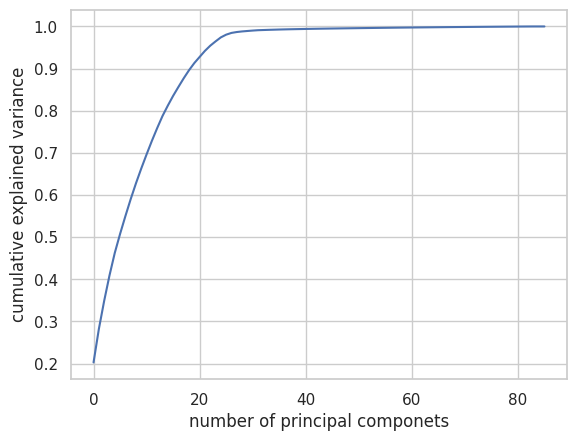

In [ ]:
# We can see that at 20 principal components contain over 90% of the variance but we need almost 40 to get closer to 100%
# We can reduce our dimensions by almost 80% with PCA

pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of principal componets')
plt.ylabel('cumulative explained variance')

In [ ]:
# creating a list to pass through as column labels for each principal component

pc_list = []
for i in range(1,21):
    if i not in pc_list:
        pc_list.append(str('pc')+str(i))

pc_list

['pc1',
 'pc2',
 'pc3',
 'pc4',
 'pc5',
 'pc6',
 'pc7',
 'pc8',
 'pc9',
 'pc10',
 'pc11',
 'pc12',
 'pc13',
 'pc14',
 'pc15',
 'pc16',
 'pc17',
 'pc18',
 'pc19',
 'pc20']

In [ ]:
# create principal component dataframe

pca = PCA(n_components=20)
principal_components = pca.fit_transform(X)
principal_df = pd.DataFrame(data = principal_components, columns = [pc_list])
principal_df.index=movies_temp.index
pca_df = pd.concat([principal_df, movies_temp[['ratingClass', 'averageRating']]], axis = 1)

In [ ]:
movies.to_csv('movies_final.csv')

In [ ]:
pca_df.to_csv('pca_df.csv', index=False)

Reset for RAM

# Part 4: Modeling
###  We will be testing 9 different classification models
* Neural network: Deep learning multi-layered methodology where each layer can process data and abstract understanding.
* Random Forest: Popular ensemble model that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.
* SVM: Support vector model as this tends to perform better with higher dimensional data which we have
* Logistic Regression: implements regularized logistic regression 
* Decision Tree: Decision tree classifier commonly measures split by gini impuirity
* KNN: Classifier implementing the k-nearest neighbors vote.
* Gradient Boosting: Gradient Boosting for classification that builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions.
* CatBoost: Classifier that uses gradient boosting on decision trees.
* Gaussian NB: Generative model that assumes each class follows a gaussian distribution

In [ ]:
%reset

In [ ]:
# standard libraries
import numpy as np
import pandas as pd
import matplotlib as plt
from statistics import mean
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate, train_test_split
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification

# classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsClassifier


# nn
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report


# visualize
import matplotlib.pyplot as plt

# never forget to supress warnings
import warnings
warnings.filterwarnings('ignore')

## 4.1 Import Dataframe

In [ ]:
movies = pd.read_csv('pca_df.csv')
# movies = pd.read_csv('movies_final.csv', index_col=0)

## 4.2 Seperate dependent and independent variables

In [ ]:
!nvidia-smi

Tue Aug  9 17:48:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.68.02    Driver Version: 512.77       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:02:00.0  On |                  N/A |
| 30%   34C    P0    45W / 220W |   1433MiB /  8192MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# test train split

X = movies.drop(columns=['averageRating', 'ratingClass'])
y = movies[['averageRating']]
y2 = movies[['ratingClass']]

In [ ]:
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X, y2, test_size=0.2, random_state=2022, stratify=y2)

In [ ]:
# casting y as categorical variables

y_train_std = tf.keras.utils.to_categorical(y_train_std)
y_test_std = tf.keras.utils.to_categorical(y_test_std)

## 4.3 Neural Network
Since I structured this as a classification problem, we can create a neural network and process on gpu for fast compute and see how it performs with various hidden layers and neuron configurations

### 4.31 Define baseline model

In [ ]:
def baseline_model(learn_rate=0.01, momentum=0):
    # create model
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(len(X_train_std.columns), input_dim=(len(X_train_std.columns)), activation='relu'))
    model.add(Dense((y_train_std.shape[1]), kernel_initializer='normal', activation='softmax')) # dense is 5 because i set 5 classification classes
    model.add(Dropout(0.2))
    # optimizer = SGD(lr=learn_rate, momentum=momentum)    # compile model
    model.compile(loss='mean_absolute_error', optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), metrics=['mae','accuracy'])
    return model

### 4.32 Evaluate baseline model

In [ ]:
#evaluate base model
np.random.seed(2022)

#evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=50, batch_size=50, verbose=1)

#using 10-fold cross validation to evaluate the model
kfold = KFold(n_splits=10, random_state=2022, shuffle=True)
results = cross_val_score(estimator, X_train_std, y_train_std, cv=kfold)

2022-08-09 17:48:47.025808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-09 17:48:47.027856: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-09 17:48:47.027945: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-08-09 17:48:47.027992: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-08-09 17:48:47.028034: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

221/221 [==============================] - 0s 986us/step - loss: 0.1975 - mae: 0.1975 - accuracy: 0.5496


### 4.33 Define deeper model

In [ ]:
# adding three more hidden layers to the base model to test

def larger_model(learn_rate=0.01, momentum=0):
    # create model
    model = Sequential()
    model.add(Dense(len(X_train_std.columns), input_dim=(len(X_train_std.columns)), kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, input_dim=(len(X_train_std.columns)), kernel_initializer='normal', activation='relu'))
    model.add(Dense(2, input_dim=(len(X_train_std.columns)), kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, input_dim=(len(X_train_std.columns)), kernel_initializer='normal', activation='relu'))
    model.add(Dense((y_train_std.shape[1]), kernel_initializer='normal', activation='softmax'))
    model.add(Dropout(0.2))
    # compile model
    # optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mean_absolute_error', optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), metrics=['mae','accuracy'])
    return model

### 4.34 Evaluate deeper model

In [ ]:
#evaluate deeper model
np.random.seed(2022)

#evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=larger_model, nb_epoch=50, batch_size=50, verbose=1)

#using 10-fold cross validation to evaluate the model
kfold = KFold(n_splits=10, random_state=2022, shuffle=True)
results = cross_val_score(estimator, X_train_std, y_train_std, cv=kfold)

221/221 [==============================] - 0s 1ms/step - loss: 0.2169 - mae: 0.2169 - accuracy: 0.4835


### 4.35 Define deeper model with more dropout

In [ ]:
# larger model with higher dropout

def larger_model_dropout(learn_rate=0.01, momentum=0):
    # create model
    model = Sequential()
    model.add(Dense(len(X_train_std.columns), input_dim=(len(X_train_std.columns)), kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, input_dim=(len(X_train_std.columns)), kernel_initializer='normal', activation='relu'))
    model.add(Dense(2, input_dim=(len(X_train_std.columns)), kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, input_dim=(len(X_train_std.columns)), kernel_initializer='normal', activation='relu'))
    model.add(Dense((y_train_std.shape[1]), kernel_initializer='normal', activation='softmax'))
    model.add(Dropout(0.5))
    # compile model
    model.compile(loss='mean_absolute_error', optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), metrics=['mae','accuracy'])
    return model

### 4.36 Evaluate deeper model with more dropout

In [ ]:
#evaluate larger model
np.random.seed(2022)

#evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=larger_model_dropout, nb_epoch=50, batch_size=50, verbose=1)

#using 10-fold cross validation to evaluate the model
kfold = KFold(n_splits=10, random_state=2022, shuffle=True)
results = cross_val_score(estimator, X_train_std, y_train_std, cv=kfold)

221/221 [==============================] - 0s 1ms/step - loss: 0.2310 - mae: 0.2310 - accuracy: 0.5235


### 4.37 Define wider model

In [ ]:
#define wider model, doubling the number of neurons in two hidden layers

def wider_model(learn_rate=0.01, momentum=0):
    # create model
    model = Sequential()
    model.add(Dense((len(X_train_std.columns))*2, input_dim=(len(X_train_std.columns)), kernel_initializer='normal', activation='relu'))
    model.add(Dense(12, input_dim=(len(X_train_std.columns)), kernel_initializer='normal', activation='relu'))
    model.add(Dense((y_train_std.shape[1]), kernel_initializer='normal', activation='softmax'))
    model.add(Dropout(0.2))
    # compile model
    model.compile(loss='mean_absolute_error', optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), metrics=['mae','accuracy'])
    return model

### 4.38 Evaluate wider model

In [ ]:
np.random.seed(2022)

#evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=wider_model, nb_epoch=50, batch_size=50, verbose=1)

#using 10-fold cross validation to evaluate the model
kfold = KFold(n_splits=10, random_state=2022, shuffle=True)
results = cross_val_score(estimator, X_train_std, y_train_std, cv=kfold)

221/221 [==============================] - 0s 986us/step - loss: 0.1987 - mae: 0.1987 - accuracy: 0.5527


### 4.39 Define wider model with more dropout

In [ ]:
def wider_model_dropout(learn_rate=0.01, momentum=0):
    model = Sequential()
    model.add(Dense((len(X_train_std.columns))*2, input_dim=(len(X_train_std.columns)), kernel_initializer='normal', activation='relu'))
    model.add(Dense(12, input_dim=(len(X_train_std.columns)), kernel_initializer='normal', activation='relu'))
    model.add(Dense((y_train_std.shape[1]), kernel_initializer='normal', activation='softmax'))
    model.add(Dropout(0.5))
    # compile model
    model.compile(loss='mean_absolute_error', optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), metrics=['mae','accuracy'])
    return model

In [ ]:
#evaluate larger model
np.random.seed(2022)

#evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=wider_model_dropout, nb_epoch=50, batch_size=50, verbose=1)

#using 10-fold cross validation to evaluate the model
kfold = KFold(n_splits=10, random_state=2022, shuffle=True)
results = cross_val_score(estimator, X_train_std, y_train_std, cv=kfold)

221/221 [==============================] - 0s 1ms/step - loss: 0.2312 - mae: 0.2312 - accuracy: 0.4794


### 4.39.1 Test wider model

In [ ]:
model = Sequential()
model.add(Dense((len(X_train_std.columns))*2, input_dim=(len(X_train_std.columns)), kernel_initializer='normal', activation='relu'))
model.add(Dense(12, input_dim=(len(X_train_std.columns)), kernel_initializer='normal', activation='relu'))
model.add(Dense((y_train_std.shape[1]), kernel_initializer='normal', activation='softmax'))
model.add(Dropout(0.2))
model.compile(loss='mean_absolute_error', optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['mae','accuracy'])

In [ ]:
model.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_180 (Dense)           (None, 40)                840       
                                                                 
 dense_181 (Dense)           (None, 12)                492       
                                                                 
 dense_182 (Dense)           (None, 5)                 65        
                                                                 
 dropout_50 (Dropout)        (None, 5)                 0         
                                                                 
Total params: 1,397
Trainable params: 1,397
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# early stopping and callback so I can save my model

es = EarlyStopping(monitor='val_accuracy', min_delta = 0.01, patience=40, verbose=1)
mc = ModelCheckpoint("/home/creeg/projects/audible/notebooks/model.h5", monitor='val_accuracy', verbose=1, save_best_only=True)
cb = [es,mc]

In [ ]:
his = model.fit(X_train_std, y_train_std, epochs=50, validation_split=0.2, callbacks = cb)

Epoch 1/50
2730/2754 [============================>.] - ETA: 0s - loss: 0.2071 - mae: 0.2071 - accuracy: 0.4805
Epoch 1: val_accuracy improved from -inf to 0.54652, saving model to /home/creeg/projects/audible/notebooks/model.h5
2754/2754 [==============================] - 5s 2ms/step - loss: 0.2070 - mae: 0.2070 - accuracy: 0.4805 - val_loss: 0.2021 - val_mae: 0.2021 - val_accuracy: 0.5465
Epoch 2/50
2730/2754 [============================>.] - ETA: 0s - loss: 0.2030 - mae: 0.2030 - accuracy: 0.4884
Epoch 2: val_accuracy improved from 0.54652 to 0.54770, saving model to /home/creeg/projects/audible/notebooks/model.h5
2754/2754 [==============================] - 4s 2ms/step - loss: 0.2029 - mae: 0.2029 - accuracy: 0.4885 - val_loss: 0.1999 - val_mae: 0.1999 - val_accuracy: 0.5477
Epoch 3/50
2738/2754 [============================>.] - ETA: 0s - loss: 0.2023 - mae: 0.2023 - accuracy: 0.4896
Epoch 3: val_accuracy improved from 0.54770 to 0.54884, saving model to /home/creeg/projects/audi

In [ ]:
model.save('audible_nn_model.h5')

In [ ]:
model_S = keras.models.load_model('audible_nn_model.h5')

### 4.39.2 Evaluate wider model

In [ ]:
score = model_S.evaluate(X_test_std, y_test_std)

861/861 [==============================] - 1s 1ms/step - loss: 0.2000 - mae: 0.2000 - accuracy: 0.5527


In [ ]:
print(his.history.keys())

dict_keys(['loss', 'mae', 'accuracy', 'val_loss', 'val_mae', 'val_accuracy'])


### 4.39.3 Evaluate accuracy
* I included drop out and early stopping so the model could avoid overfitting since this can be a big problem with neurnal networks. 
* The model accuracy did much better on test than on train and looks like I am actually underfitting traing since the model generalizes well on test according to accuracy. I could tune the parameters by doing things like reducing dropout and increasing epochs.

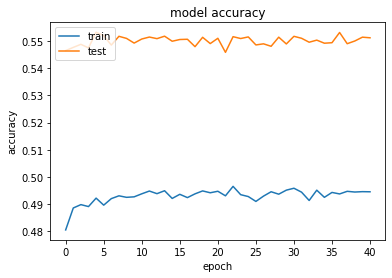

In [ ]:
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 4.39.4 Evaluate loss

* You can see that the model has comparable performance on both train and test for until ~10 epochs - the divergece after means we could probably reduce patience. 
* Since the loss on test is consistently worse than on training until 20 epochs it looks like this model is underfit and I could use tuning from parameters like number of epochs and dropout

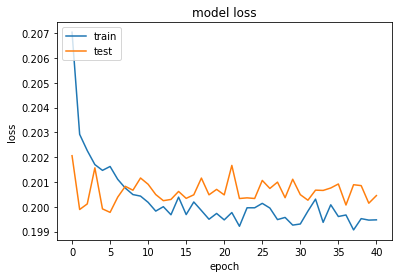

In [ ]:
# summarize history for loss
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 4.39.4 Evaluate classifications

* The model didn't perform as well on classifying lower rating films.
* This makes sense since the categorical features I hot encoded were things like directors and actors that have been in the most films which may be related to movie ratings and ultimately budget. Also, there aren't as many low rated films in the data even after grouping 0-2 together.
* It may be worthwhile to make features for directors/actors/cast that have been in top quartile number of films in the dataset and lowest quartile

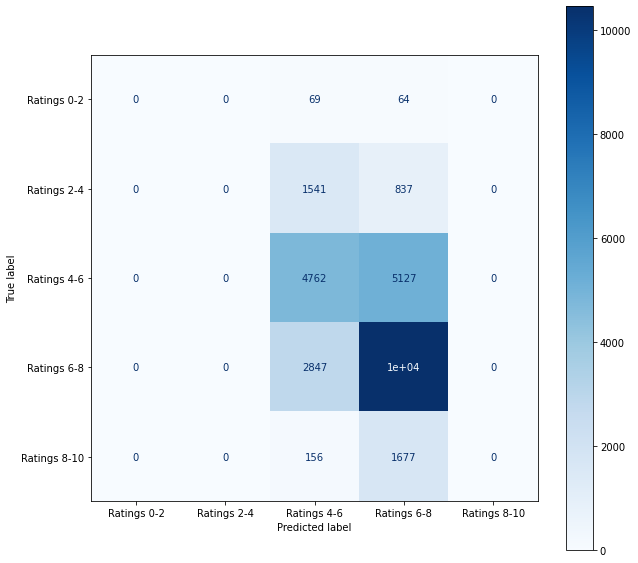

In [ ]:
# get predictions
y_pred = model.predict(X_test_std)

# create confusion matrix
cm = confusion_matrix(y_test_std.argmax(axis=1), y_pred.argmax(axis=1))

# create human readable labels
labels = ['Ratings 0-2', 'Ratings 2-4', 'Ratings 4-6', 'Ratings 6-8', 'Ratings 8-10']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))

# plot results
disp.plot(ax=ax,cmap=plt.cm.Blues)


In [ ]:
# proportion of true positive classifications that were actually correct (tp/tp+fp)
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()

# proportion of true positives that were identified correctly (tp/tp+fn)
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

# simple average score of all classes (mean score of the 5 rating classes)
def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

# proportion of correct predictions out of total predictions (tp+tn/tp+tn+fp+fn)
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [ ]:
accuracy(cm)

0.552723311546841

In [ ]:
print("recall total:", recall_macro_average(cm))

recall total: 0.2535195209547857


In [ ]:
print("label precision recall")
for label in range(5):
    print(f"{label:5d} {precision(label, cm):9.3f} {recall(label, cm):6.3f}")

label precision recall
    0       nan  0.000
    1       nan  0.000
    2     0.508  0.482
    3     0.576  0.786
    4       nan  0.000


In [ ]:
y_pred_t = (y_pred > 0.5)

In [ ]:
# summarized metrics

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_std, y_pred_t)))
print("ROC AUC Score:",roc_auc_score(y_test_std, y_pred_t, average='micro'))
print('Micro Precision: {:.2f}'.format(precision_score(y_test_std, y_pred_t, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_std, y_pred_t, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_std, y_pred_t, average='micro')))
print('Macro Precision: {:.2f}'.format(precision_score(y_test_std, y_pred_t, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_std, y_pred_t, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_std, y_pred_t, average='macro')))
print('Weighted Precision: {:.2f}'.format(precision_score(y_test_std, y_pred_t, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_std, y_pred_t, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_std, y_pred_t, average='weighted')))


Accuracy: 0.55

ROC AUC Score: 0.7204520697167757
Micro Precision: 0.55
Micro Recall: 0.55
Micro F1-score: 0.55

Macro Precision: 0.22
Macro Recall: 0.25
Macro F1-score: 0.23

Weighted Precision: 0.46
Weighted Recall: 0.55
Weighted F1-score: 0.50


In [ ]:
print('\nClassification Report\n')
print(classification_report(y_test_std, y_pred_t, target_names=labels))


Classification Report

              precision    recall  f1-score   support

 Ratings 0-2       0.00      0.00      0.00       133
 Ratings 2-4       0.00      0.00      0.00      2378
 Ratings 4-6       0.51      0.48      0.49      9889
 Ratings 6-8       0.58      0.79      0.66     13307
Ratings 8-10       0.00      0.00      0.00      1833

   micro avg       0.55      0.55      0.55     27540
   macro avg       0.22      0.25      0.23     27540
weighted avg       0.46      0.55      0.50     27540
 samples avg       0.55      0.55      0.55     27540



### 4.39.3 Neural Network Findings

* Wider model (model with more neurons) performs a bit better than deeper model
* AUC ROC score indicates the model can distinguish between classes but I believe it requires more tuning, additioanl data-preprocessing, and potentially external data to get above 90% threshold
* Micro average is a little misleading over 50% number of movies were properly classified but they are predominatly related to ratings between 5-8 and the majority of movies have ratings between 5-8. Micro average captures this class imbalance and calls attention to the fact that movies on the lower and higher end of the rating scale aren't being classified correctly
* Did not not see much improvement across 50 epochs so that also warrants tuning epochs and looking at different loss metrics
* Exploring additional data preprocessing through feature engineering for more meaningful features and bringing in external data are good next steps to improve results.



## 4.4 Other classification models

* We will be using RandomizedGridSearchCV to go through hyperparameters and find the optimal non neural network model for classification

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.2, random_state=2022, stratify=y2)

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

### 4.41 Initialize models

In [ ]:
# Initialize classifiers

clf1 = RandomForestClassifier(random_state=2022)
clf2 = SVC(probability=True, random_state=2022)
clf3 = LogisticRegression(random_state=2022)
clf4 = DecisionTreeClassifier(random_state=2022)
clf5 = KNeighborsClassifier()
clf6 = GradientBoostingClassifier(random_state=2022)
clf7 = CatBoostClassifier(silent = True)
clf8 = GaussianNB()

In [ ]:
param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__max_depth'] = [5, 10, 20]
param1['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param2['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param2['classifier'] = [clf2]

param3 = {}
param3['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param3['classifier__penalty'] = ['l1']
param3['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param3['classifier'] = [clf3]

param4 = {}
param4['classifier__max_depth'] = [5,10,25,None]
param4['classifier__min_samples_split'] = [2,5,10]
param4['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param4['classifier'] = [clf4]

param5 = {}
param5['classifier__n_neighbors'] = [2,5,10,25,50]
param5['classifier'] = [clf5]

param6 = {}
param6['classifier__n_estimators'] = [10, 50, 100, 250]
param6['classifier__max_depth'] = [5, 10, 20]
param6['classifier'] = [clf6]

param7 = {}
param7['classifier__depth'] = [1, 2, 3]
param7['classifier__learning_rate'] = [0.001, 0.002, 0.003]
param7['classifier'] = [clf7]

param8 = {}
param8['classifier__var_smoothing'] = [np.logspace(0, -9, num = 100)]
param8['classifier'] = [clf8]

In [ ]:
pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2, param3, param4, param5, param6, param7, param8]

### 4.42 Hyperparameter tuning
* searching for optimal hyperparamters
* initially was using gridsearchcv but switched to randomizedsearchcv to save time

In [ ]:
%%time
# Train the grid search model
scoring = ['accuracy','f1_macro']
gs = RandomizedSearchCV(pipeline, params, cv=10, n_jobs=-1, scoring=scoring, return_train_score=True, refit='accuracy').fit(X_train, y_train)

CPU times: user 5.96 s, sys: 0 ns, total: 5.96 s
Wall time: 3min 53s


### 4.43 Model selection
* RandomForest is the winner with 10 estimates at max depth 20

In [ ]:
gs.best_params_

{'classifier__n_estimators': 10,
 'classifier__max_depth': 20,
 'classifier__class_weight': None,
 'classifier': RandomForestClassifier(max_depth=20, n_estimators=10, random_state=2022)}

In [ ]:
gs.best_score_

0.427827078411264

### 4.44 RandomForest evaluation

In [ ]:
# Test data performance
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(gs.predict(X_test), y_test)))
print("Test ROC AUC Score:",roc_auc_score(gs.predict(X_test), y_test, average='micro'))
print("Micro Precision:",precision_score(gs.predict(X_test), y_test, average='micro'))
print('Micro Recall: {:.2f}'.format(recall_score(gs.predict(X_test), y_test, average='micro')))
print("Micro F1 Score:",f1_score(gs.predict(X_test), y_test, average='micro'))
print('Macro Precision: {:.2f}'.format(precision_score(gs.predict(X_test), y_test, average='macro')))
print("Macro Recall:",recall_score(gs.predict(X_test), y_test, average='macro'))
print("Macro F1 Score:",f1_score(gs.predict(X_test), y_test, average='macro'))
print("Weighted Precision:",precision_score(gs.predict(X_test), y_test, average='weighted'))
print('Weighted Recall: {:.2f}'.format(recall_score(gs.predict(X_test), y_test, average='weighted')))
print("Weighted F1 Score:",f1_score(gs.predict(X_test), y_test, average='weighted'))



Accuracy: 0.43

Test ROC AUC Score: 0.7023293554919661
Micro Precision: 0.4271604938271605
Micro Recall: 0.54
Micro F1 Score: 0.47728010386238234
Macro Precision: 0.23
Macro Recall: 0.37248070437521297
Macro F1 Score: 0.2598656740017674
Weighted Precision: 0.48537264087953197
Weighted Recall: 0.54
Weighted F1 Score: 0.5064366077401492


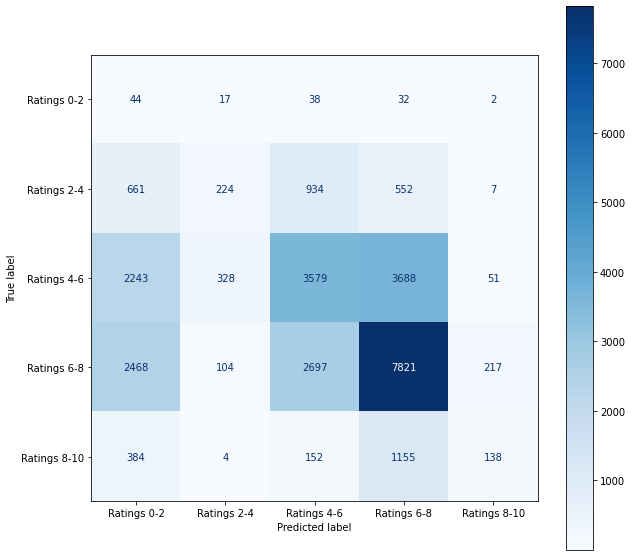

In [ ]:
# get predictions
forest = RandomForestClassifier(max_depth=20, n_estimators=10, random_state=2022)
forest.fit(X_train, y_train)

forest_pred = forest.predict(X_test)

# create confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), forest_pred.argmax(axis=1))

# create human readable labels
labels = ['Ratings 0-2', 'Ratings 2-4', 'Ratings 4-6', 'Ratings 6-8', 'Ratings 8-10']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))

# plot results
disp.plot(ax=ax,cmap=plt.cm.Blues)

### 4.45 RandomForest feature attribution

In [ ]:
importances = forest.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

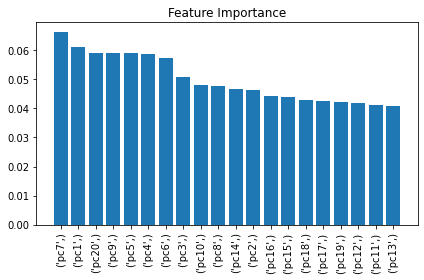

In [ ]:
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

### 4.45 RandomForest Findings

* Random forest classifier performed the best out of the classifiers
* PCA feature importance is interesting since I would think PC1 would be the most important feature. I would probably try to obtain more inforamtion using gini impurity index on the raw features with additional time
* I would be intersted to see if combinations of actors or directors in genres and regions have correlation with rating

# Part 5: Conclusion

* Random forest classifier performed the best out of the classifiers but neural network had higher overall accuracy
* Both models had issues predicting 0-2 and 8-10 according to the confusion matrix but the neural network had over 10% higher micro precision which means it was better at classifying true positives
* Although accuracy was 12% higher for the neural network, Random forest had 12% higher macro-recall, which indicates that it was better at classifying less common classes than the neural network
* Both models were able to identify different classes according to similar ROC AUC scores of over 70%
* Next steps to improve the models are to identify more impactful features through feature engineering and to include external data

## 5.1 Appendix

Neural Network:
* Accuracy: 0.55 
* ROC AUC Score: 0.72
* Micro Precision: 0.55 
* Micro Recall: 0.55 
* Micro F1-score: 0.55 
* Macro Precision: 0.22 
* Macro Recall: 0.25 
* Macro F1-score: 0.23 
* Weighted Precision: 0.46 
* Weighted Recall: 0.55 
* Weighted F1-score: 0.50

Random Forest:
* Accuracy: 0.43
* Test ROC AUC Score: 0.70
* Micro Precision: 0.43
* Micro Recall: 0.54 
* Micro F1 Score: 0.48
* Macro Precision: 0.23 
* Macro Recall: 0.37
* Macro F1 Score: 0.26
* Weighted Precision: 0.49
* Weighted Recall: 0.54 
* Weighted F1 Score: 0.51